What is the purpose of this? 

This model is meant to show that the use of the csvs metric on blinded typical data can be used to predict how a model perfoms on truly cold start examples (pharos)

Trying to show that:

- Deviation behavior on blinded data (CSVS) can be quantified

- The behavior generalizes — can predict model errors on cold-start samples

- So CSVS can act as a model evaluation tool even when no Pharos-type cold-start labels are available

# Model Level

# Protein Level

In [170]:
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull

def compute_CHR_per_protein(merged_df):
    #based on convex hull:  how often the model predicts out-of-distribution values when faced with a cold-start protein.
    CHR_dict = {}

    for protein_id, group in merged_df.groupby("Protein_ID"):
        points_unblinded = group[["True_Label", "Unblinded_Prediction"]].values
        points_blinded = group[["True_Label", "Blinded_Prediction"]].values

        if len(points_unblinded) < 3:
            print("<3")
            continue  # Need at least 3 points for a convex hull

        try:
            hull = ConvexHull(points_unblinded)
            polygon = Polygon(points_unblinded[hull.vertices])

            inside_mask = np.array([polygon.contains(Point(p)) for p in points_blinded])
            outside_count = (~inside_mask).sum()
            CHR = outside_count / len(points_blinded)
            CHR_dict[protein_id] = CHR
        except Exception as e:
            print(f"[EXCEPTION] Protein: {protein_id} — {str(e)}")
            continue

    return pd.Series(CHR_dict)


def compute_CSPD_per_protein(merged_df):
    #how much a model’s prediction changes for the same input when the protein is blinded
    merged_df["NPD"] = (
        merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]
    ) / merged_df["True_Label"]

    CSPD = merged_df.groupby("Protein_ID")["NPD"].mean()
    return CSPD.rename("CSPD")


def compute_CSVS_protein_level(merged_df, alpha=None, beta=None):
    # Step 1: Get per-protein CSPD and CHR
    CSPD_per_protein = compute_CSPD_per_protein(merged_df)
    CHR_per_protein = compute_CHR_per_protein(merged_df)

    # Align proteins
    common_proteins = CSPD_per_protein.index.intersection(CHR_per_protein.index)
    CSPD = CSPD_per_protein.loc[common_proteins].abs()
    CHR = CHR_per_protein.loc[common_proteins]

    # Normalize weights if not provided
    if alpha is None:
        alpha = 1 / CSPD.max()
    if beta is None:
        beta = 1 / CHR.max()

    # Compute CSVS for each protein
    csvs_per_protein = alpha * CSPD + beta * CHR
    print(csvs_per_protein)

    # Return the protein-level CSVS (mean across proteins)
    csvs_model = csvs_per_protein.mean()
    return csvs_model, csvs_per_protein, alpha, beta



379


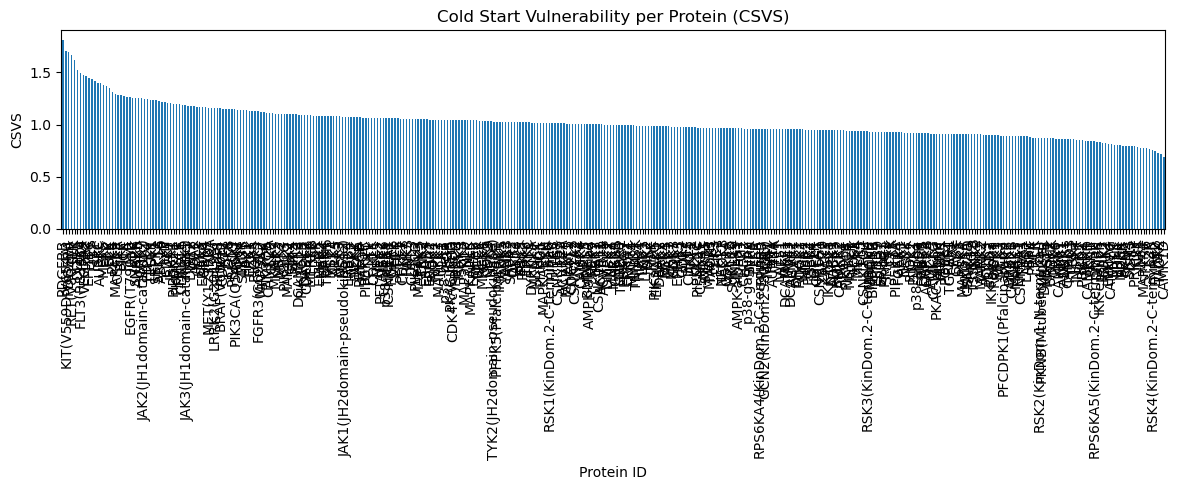

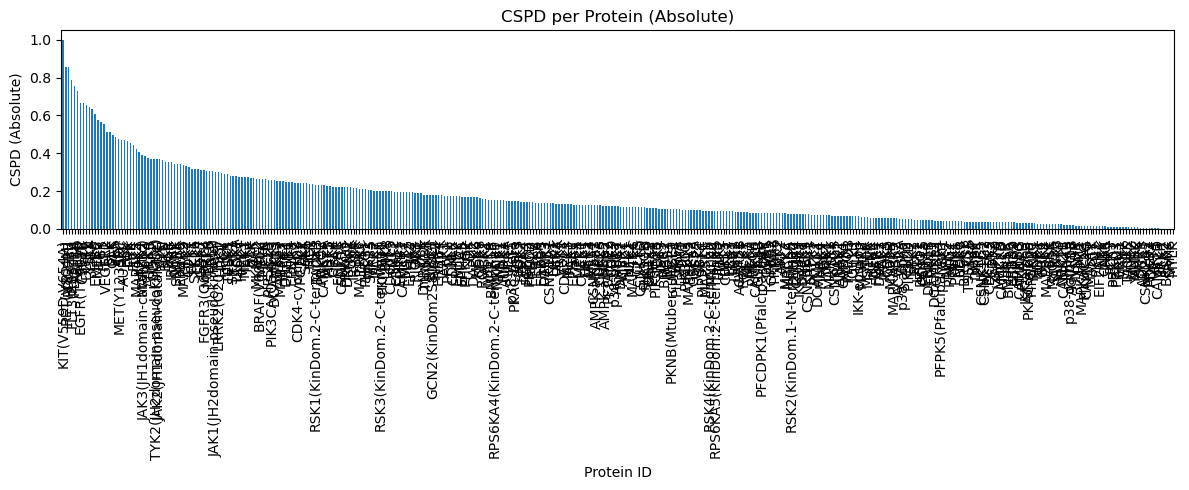

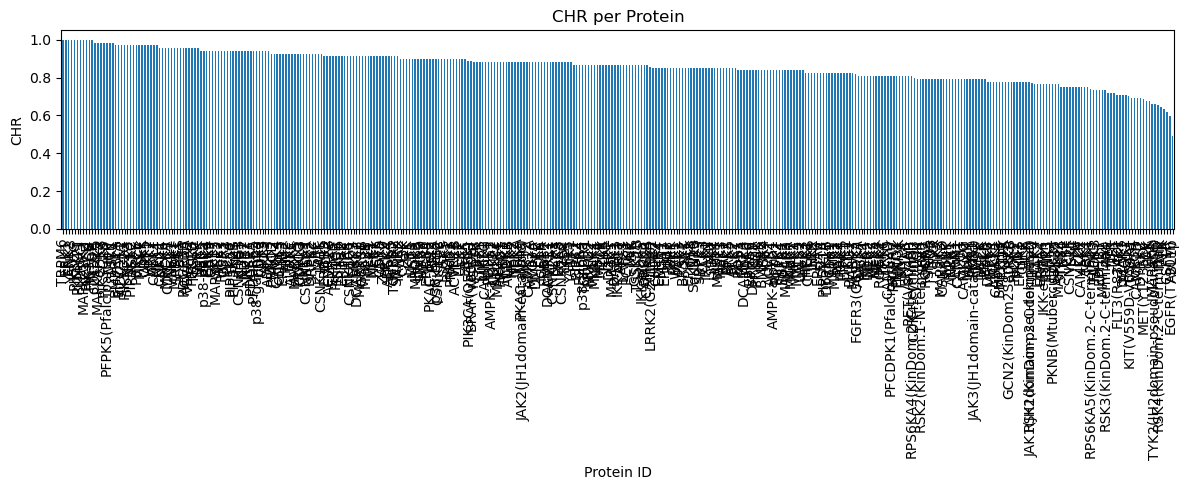

AAK1         0.925310
ABL1p        1.219273
ABL2         1.171596
ACVR1        0.955878
ACVR1B       0.916396
               ...   
ZAP70        0.948994
p38-alpha    0.920834
p38-beta     1.044967
p38-delta    1.062619
p38-gamma    0.962285
Length: 379, dtype: float64
Model-level CSVS: 1.0228
Alpha scaling: 4.5980, Beta scaling: 1.0000


In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load both files
df_unblinded = pd.read_csv(unblinded_file)
df_blinded = pd.read_csv(blinded_file)

# Rename prediction columns to distinguish
df_unblinded = df_unblinded.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
df_blinded = df_blinded.rename(columns={"Predicted_Value": "Blinded_Prediction"})

# Merge on Drug_ID and Protein_ID
merged_df = pd.merge(
    df_unblinded[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    df_blinded[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

# Compute CSPD and CHR
CSPD_per_protein = compute_CSPD_per_protein(merged_df)
CSPD_abs = CSPD_per_protein.abs()
CHR_per_protein = compute_CHR_per_protein(merged_df)
print(len(CHR_per_protein))

# Normalize weights
alpha = 1 / CSPD_abs.max()
beta = 1 / CHR_per_protein.max()

# Combine into CSVS
csvs = alpha * CSPD_abs + beta * CHR_per_protein

# Plot CSVS
csvs.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title="Cold Start Vulnerability per Protein (CSVS)")
plt.ylabel("CSVS")
plt.xlabel("Protein ID")
plt.tight_layout()
plt.show()

# Plot CSPD
CSPD_abs_normalized = CSPD_abs*alpha
CSPD_abs_normalized.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title="CSPD per Protein (Absolute)")
plt.ylabel("CSPD (Absolute)")
plt.xlabel("Protein ID")
plt.tight_layout()
plt.show()

# Plot CHR
CHR_per_protein_normalized = CHR_per_protein*beta
CHR_per_protein_normalized.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title="CHR per Protein")
plt.ylabel("CHR")
plt.xlabel("Protein ID")
plt.tight_layout()
plt.show()

# Compute model-level CSVS
csvs_model, csvs_per_protein, alpha_used, beta_used = compute_CSVS_protein_level(merged_df)

print(f"Model-level CSVS: {csvs_model:.4f}")
print(f"Alpha scaling: {alpha_used:.4f}, Beta scaling: {beta_used:.4f}")


In [172]:
import pickle
with open("esm1b_protein_embeddings.pkl", "rb") as f:
    protein_embeddings = pickle.load(f)

In [173]:
import pandas as pd

# Load protein sequences
pharos_df = pd.read_csv("pharos_with_ids.csv")
davis_df = pd.concat([
    pd.read_csv("../data/davis_b3_test.csv"),
    pd.read_csv("../data/davis_b3_train.csv")
], ignore_index=True)

# Get sets of protein IDs
davis_protein_ids = set(davis_df["protein_id"])
pharos_protein_ids = set(pharos_df["prot_id"])



In [174]:
# Keep only valid IDs that are actually in the embedding dictionary
davis_embeddings = {pid: protein_embeddings[pid] for pid in davis_protein_ids if pid in protein_embeddings}
pharos_embeddings = {pid: protein_embeddings[pid] for pid in pharos_protein_ids if pid in protein_embeddings}

print(f"{len(davis_embeddings)} DAVIS proteins with embeddings")
print(f"{len(pharos_embeddings)} PHAROS proteins with embeddings")


379 DAVIS proteins with embeddings
28 PHAROS proteins with embeddings


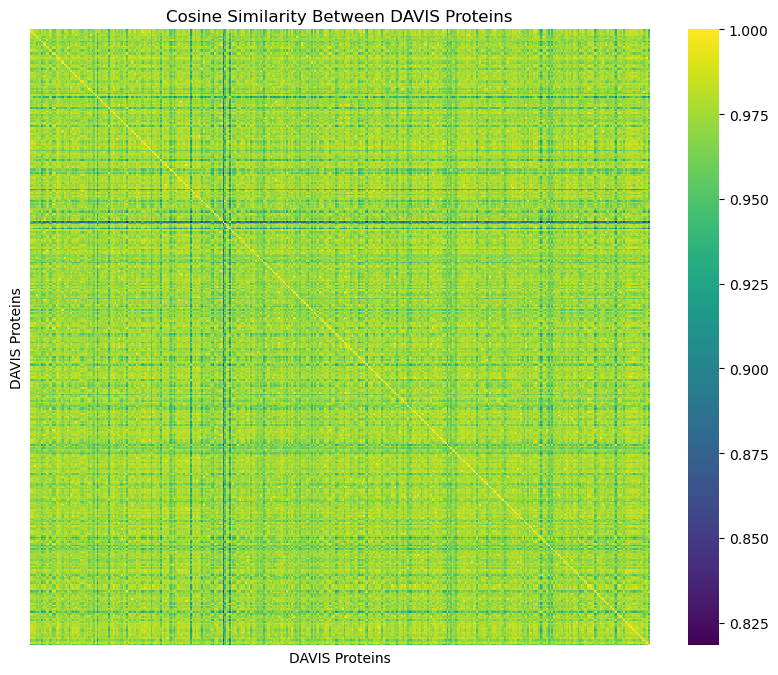

In [175]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Matrix of DAVIS embeddings
davis_ids = list(davis_embeddings.keys())
davis_matrix = np.stack([davis_embeddings[pid] for pid in davis_ids])

# Compute cosine similarity matrix
sim_matrix = cosine_similarity(davis_matrix)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, xticklabels=False, yticklabels=False, cmap="viridis")
plt.title("Cosine Similarity Between DAVIS Proteins")
plt.xlabel("DAVIS Proteins")
plt.ylabel("DAVIS Proteins")
plt.show()


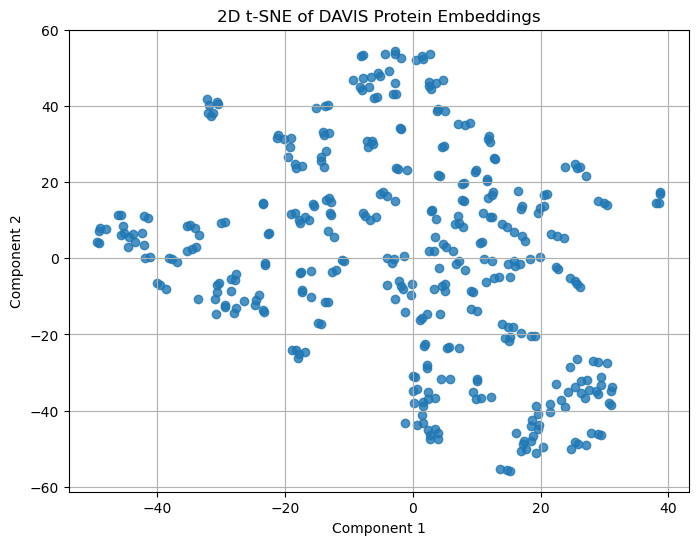

In [176]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce to 2D with t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
proj_2d = tsne.fit_transform(davis_matrix)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(proj_2d[:, 0], proj_2d[:, 1], alpha=0.8)
plt.title("2D t-SNE of DAVIS Protein Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


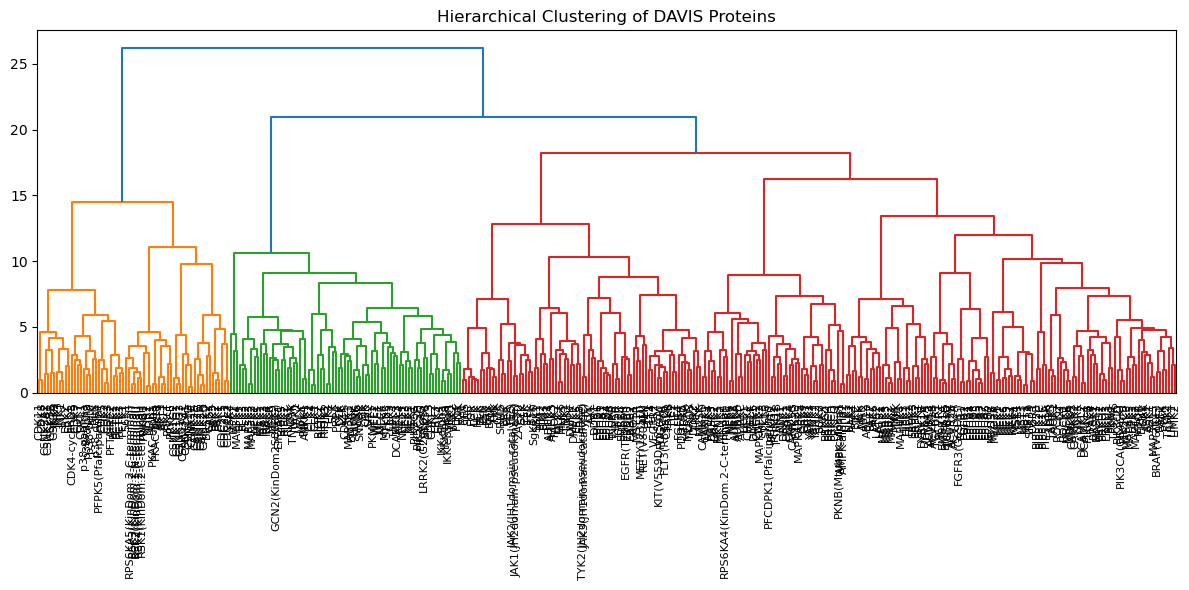

In [177]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Z = linkage(davis_matrix, method='ward')  # you can also try 'average', 'complete'

plt.figure(figsize=(12, 6))
dendrogram(Z, labels=davis_ids, leaf_rotation=90, leaf_font_size=8)
plt.title("Hierarchical Clustering of DAVIS Proteins")
plt.tight_layout()
plt.show()


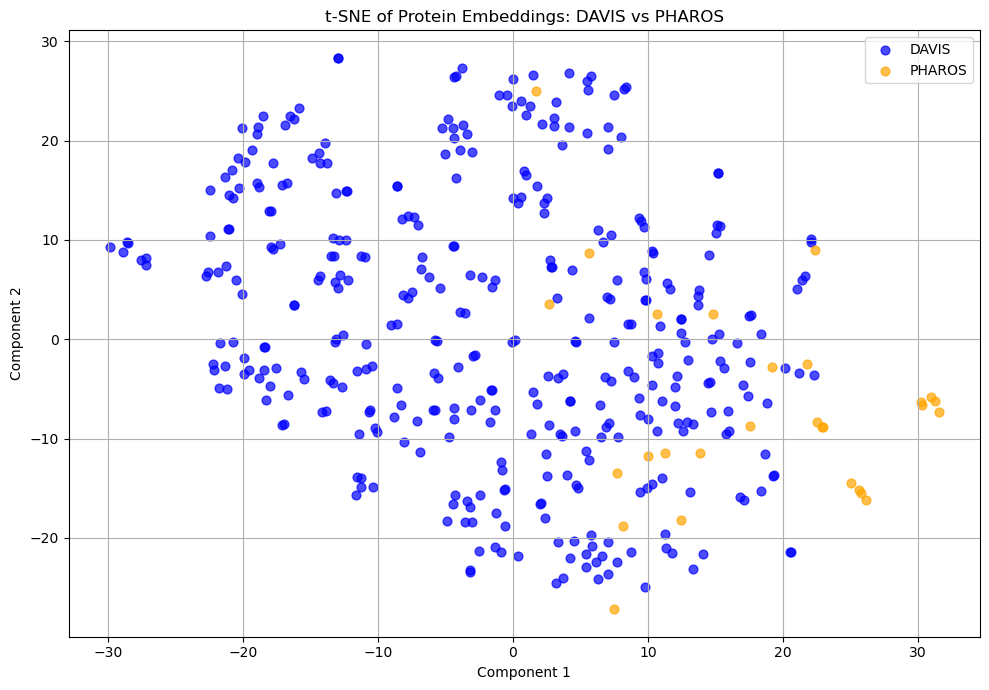

In [178]:
# Prepare data for t-SNE
davis_matrix = np.stack(list(davis_embeddings.values()))
pharos_matrix = np.stack(list(pharos_embeddings.values()))
all_embeddings = np.vstack([davis_matrix, pharos_matrix])
labels = (
    ["DAVIS"] * len(davis_embeddings)
    + ["PHAROS"] * len(pharos_embeddings)
)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
proj_2d = tsne.fit_transform(all_embeddings)

# Plot
plt.figure(figsize=(10, 7))
colors = {"DAVIS": "blue", "PHAROS": "orange"}
for label in ["DAVIS", "PHAROS"]:
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(proj_2d[idxs, 0], proj_2d[idxs, 1], label=label, alpha=0.7, s=40, c=colors[label])

plt.title("t-SNE of Protein Embeddings: DAVIS vs PHAROS")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# REDOO THISSSS

/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_4768/1199970260.py:62: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


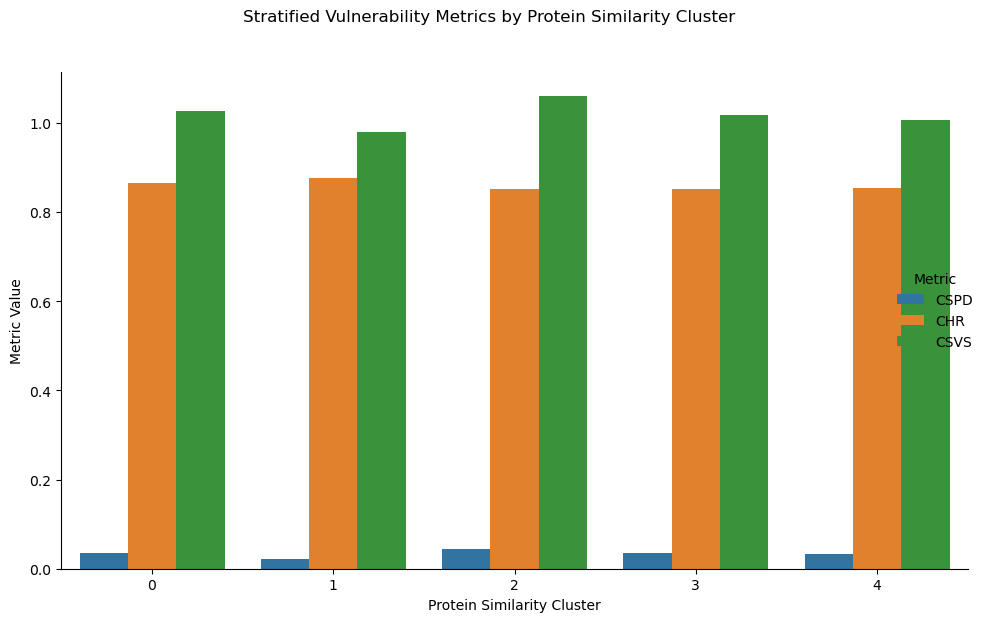

In [179]:
# Compute CSPD and CHR using your existing functions
CSPD_per_protein = compute_CSPD_per_protein(merged_df)
CSPD_abs = CSPD_per_protein.abs()
CHR_per_protein = compute_CHR_per_protein(merged_df)

# Normalize weights and compute CSVS
alpha = 1 / CSPD_abs.max()
beta = 1 / CHR_per_protein.max()
csvs = alpha * CSPD_abs + beta * CHR_per_protein
protein_csvs = pd.Series(csvs.values, index=csvs.index, name="CSVS")

# Combine into a metrics dataframe
metrics_df = pd.DataFrame({
    "Protein_ID": CSPD_abs.index,
    "CSPD": CSPD_abs,
    "CHR": CHR_per_protein,
    "CSVS": csvs
})

# Add metrics to a new copy of merged_df
merged_df_with_metrics = merged_df.merge(metrics_df, on="Protein_ID", how="left")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Get unique proteins with complete metric info and available embeddings
protein_ids = merged_df_with_metrics["Protein_ID"].dropna().unique()
valid_ids = [pid for pid in protein_ids if pid in protein_embeddings]
valid_embeddings = np.stack([protein_embeddings[pid] for pid in valid_ids])

# KMeans clustering on embeddings
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(valid_embeddings)
cluster_map = pd.Series(clusters, index=valid_ids, name="Protein_Cluster")

# Fix: convert cluster_map Series to DataFrame with a proper index name
cluster_df = cluster_map.rename_axis("Protein_ID").reset_index()

# Group metrics per protein and merge with cluster labels
summary_df = (
    merged_df_with_metrics
    .dropna(subset=["CSVS", "CSPD", "CHR"])
    .groupby("Protein_ID")[["CSPD", "CHR", "CSVS"]]
    .mean()
    .reset_index()  # Make Protein_ID a column
    .merge(cluster_df, on="Protein_ID", how="inner")  # Correct join
)


# Melt for plotting
summary_melted = summary_df.melt(
    id_vars=["Protein_ID", "Protein_Cluster"],
    value_vars=["CSPD", "CHR", "CSVS"],
    var_name="Metric", value_name="Value"
)


# Plot
g = sns.catplot(
    data=summary_melted,
    kind="bar",
    x="Protein_Cluster", y="Value", hue="Metric",
    height=6, aspect=1.5, ci=None
)
g.set_axis_labels("Protein Similarity Cluster", "Metric Value")
g._legend.set_title("Metric")
g.fig.suptitle("Stratified Vulnerability Metrics by Protein Similarity Cluster", y=1.03)
plt.tight_layout()


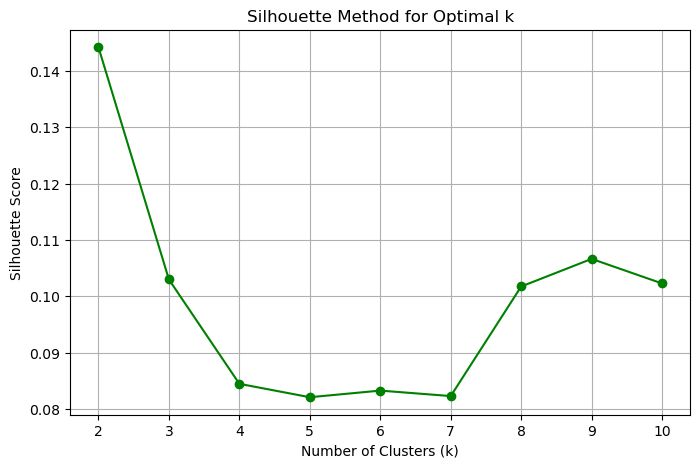

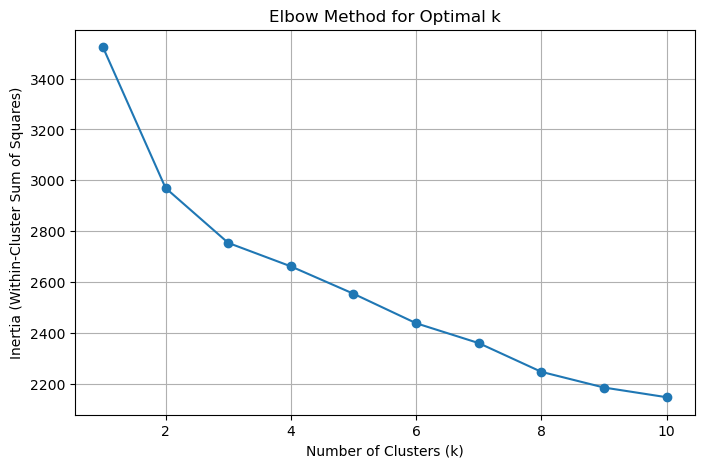

In [180]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

# Try for k from 2 to 10 (must be at least 2 for silhouette)
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(valid_embeddings)
    score = silhouette_score(valid_embeddings, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.grid(True)
plt.show()
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Create a list of K values to try
K_range = range(1, 11)  # Try 1 to 10 clusters
inertias = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(valid_embeddings)  # valid_embeddings = stacked protein embeddings
    inertias.append(kmeans.inertia_)

# Plot inertia vs number of clusters
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()



/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_4768/1494505130.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


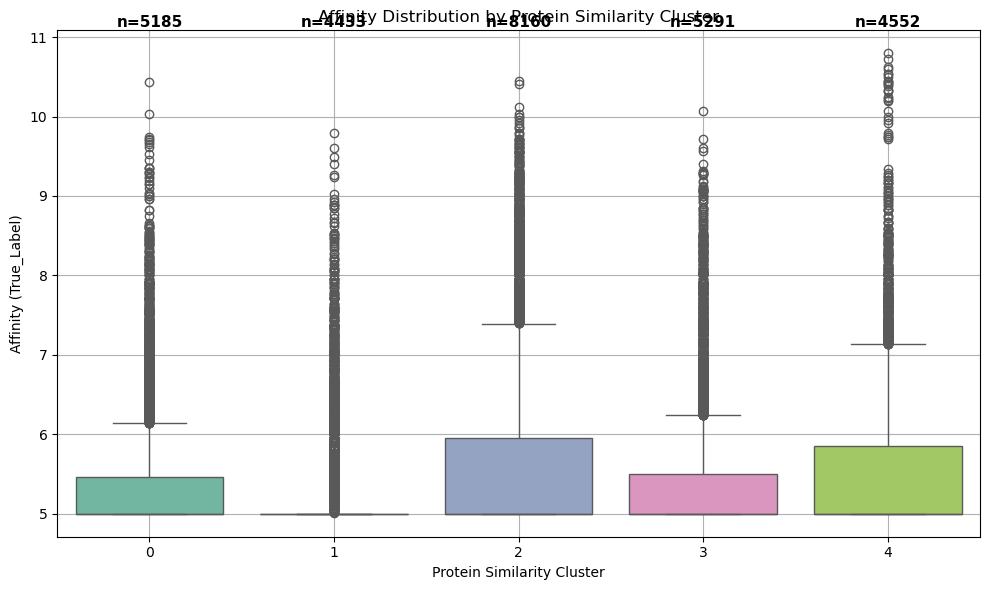

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

# Fix index name just in case
cluster_map.index.name = "Protein_ID"

# Merge cluster info
affinity_df = df_unblinded.merge(
    cluster_map.rename("Protein_Cluster"), on="Protein_ID", how="inner"
)

# Create the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=affinity_df,
    x="Protein_Cluster",
    y="True_Label",
    palette="Set2"
)

# Count number of samples per cluster
cluster_counts = (
    affinity_df.groupby("Protein_Cluster")["True_Label"]
    .count()
    .sort_index()
)

# Add counts above each box
for i, count in enumerate(cluster_counts):
    ax.text(i, ax.get_ylim()[1], f"n={count}", ha="center", va="bottom", fontsize=11, fontweight="bold")

# Final plot settings
plt.xlabel("Protein Similarity Cluster")
plt.ylabel("Affinity (True_Label)")
plt.title("Affinity Distribution by Protein Similarity Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


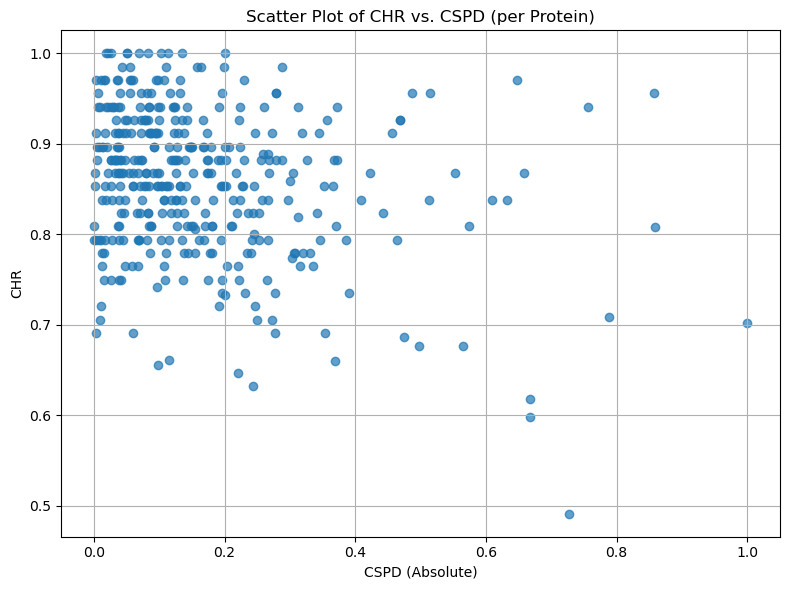

In [182]:
import matplotlib.pyplot as plt

# Ensure indices align
common_proteins = CSPD_abs.index.intersection(CHR_per_protein.index)
cspd_vals = CSPD_abs_normalized.loc[common_proteins]
chr_vals = CHR_per_protein_normalized.loc[common_proteins]

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(cspd_vals, chr_vals, alpha=0.7)

# Labeling
# for protein in common_proteins:
#     plt.annotate(protein, (cspd_vals[protein], chr_vals[protein]), fontsize=8, alpha=0.7)

plt.title("Scatter Plot of CHR vs. CSPD (per Protein)")
plt.xlabel("CSPD (Absolute)")
plt.ylabel("CHR")
plt.grid(True)
plt.tight_layout()
plt.show()


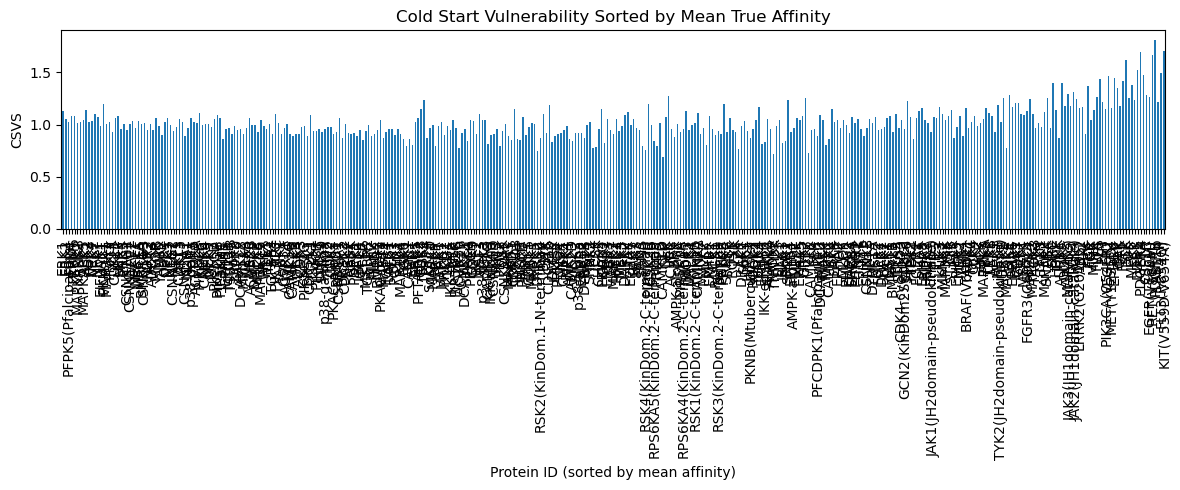

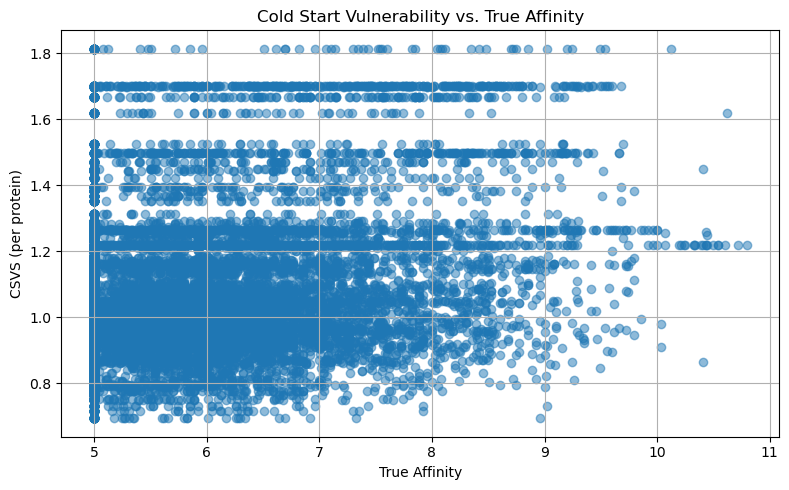

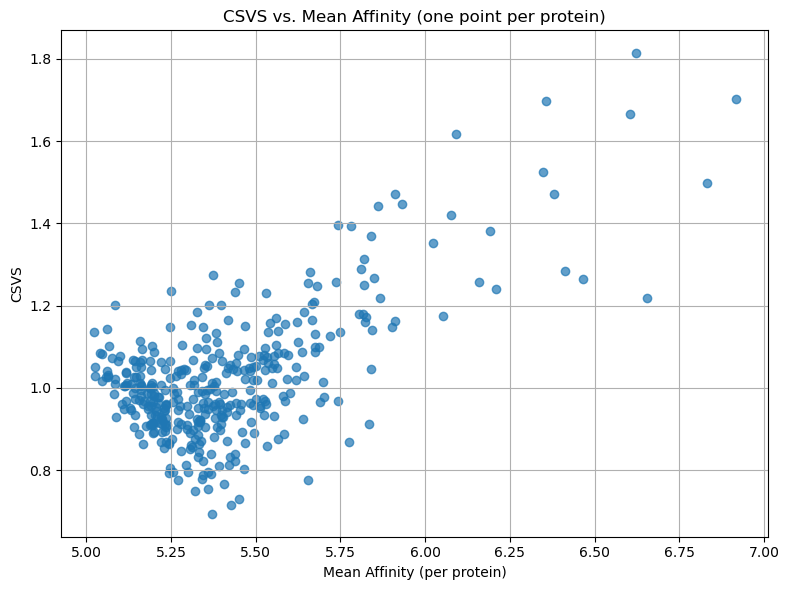

In [183]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Get the mean true affinity per protein from merged_df
mean_affinity_per_protein = merged_df.groupby("Protein_ID")["True_Label"].mean()

# Step 2: Ensure CSVS values are in a DataFrame for merging
csvs_df = pd.DataFrame({"Protein_ID": csvs.index, "CSVS": csvs.values})
csvs_df = csvs_df.set_index("Protein_ID")

# Step 3: Join with mean affinity
csvs_with_affinity = csvs_df.join(mean_affinity_per_protein)

# Step 4: Sort by True Affinity
csvs_sorted_by_affinity = csvs_with_affinity.sort_values("True_Label")

# Step 5: Plot
csvs_sorted_by_affinity["CSVS"].plot(kind='bar', figsize=(12, 5), title="Cold Start Vulnerability Sorted by Mean True Affinity")
plt.ylabel("CSVS")
plt.xlabel("Protein ID (sorted by mean affinity)")
plt.tight_layout()
plt.show()


# Step 1: Map per-protein CSVS to each row in merged_df
merged_df["CSVS"] = merged_df["Protein_ID"].map(csvs)

# Step 2: Plot CSVS vs. True Affinity
plt.figure(figsize=(8, 5))
plt.scatter(merged_df["True_Label"], merged_df["CSVS"], alpha=0.5)
plt.title("Cold Start Vulnerability vs. True Affinity")
plt.xlabel("True Affinity")
plt.ylabel("CSVS (per protein)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute mean affinity per protein
mean_affinity = merged_df.groupby("Protein_ID")["True_Label"].mean()
df_plot = pd.DataFrame({
    "CSVS": csvs_per_protein,
    "Mean_Affinity": mean_affinity
}).dropna()

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_plot["Mean_Affinity"], df_plot["CSVS"], alpha=0.7)
plt.xlabel("Mean Affinity (per protein)")
plt.ylabel("CSVS")
plt.title("CSVS vs. Mean Affinity (one point per protein)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Affinity Level

In [184]:
# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load both files
unblinded_df = pd.read_csv(unblinded_file)
blinded_df = pd.read_csv(blinded_file)

# Rename prediction columns to distinguish
unblinded_df = unblinded_df.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
blinded_df = blinded_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})

# Merge on Drug_ID and Protein_ID
merged_df = pd.merge(
    unblinded_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    blinded_df[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

In [185]:
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull

def compute_CHR_per_affinity_level(merged_df, min_affinity=5):
    """
    Computes CHR per floored integer affinity level ≥ min_affinity.
    """
    merged_df["Affinity_Level"] = merged_df["Blinded_Prediction"].astype(int)
    CHR_dict = {}

    for level, group in merged_df.groupby("Affinity_Level"):
        if level < min_affinity:
            continue

        points_unblinded = group[["True_Label", "Unblinded_Prediction"]].values
        points_blinded = group[["True_Label", "Blinded_Prediction"]].values

        if len(points_unblinded) < 3:
            continue  # Convex hull requires ≥3 points

        try:
            hull = ConvexHull(points_unblinded)
            polygon = Polygon(points_unblinded[hull.vertices])

            inside_mask = np.array([polygon.contains(Point(p)) for p in points_blinded])
            CHR = (~inside_mask).sum() / len(points_blinded)
            CHR_dict[level] = CHR
        except:
            continue  # Skip degenerate or collinear cases

    return pd.Series(CHR_dict)


def compute_CSPD_per_affinity_level(merged_df, min_affinity=5):
    """
    Computes CSPD per floored integer affinity level ≥ min_affinity.
    """
    merged_df["NPD"] = (
        merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]
    ) / merged_df["True_Label"]

    #merged_df["Affinity_Level"] = merged_df["True_Label"].astype(int)
    merged_df["Affinity_Level"] = merged_df["Blinded_Prediction"].astype(int)
    CSPD = merged_df.groupby("Affinity_Level")["NPD"].mean()
    return CSPD[CSPD.index >= min_affinity].abs().rename("CSPD")


def compute_CSVS_affinity_level(merged_df, min_affinity=5, alpha=None, beta=None):
    """
    Combines CSPD and CHR per integer affinity level ≥ min_affinity.
    Returns model-level CSVS and per-affinity-level scores.
    """
    CSPD = compute_CSPD_per_affinity_level(merged_df, min_affinity)
    CHR = compute_CHR_per_affinity_level(merged_df, min_affinity)

    # Align levels
    common_levels = CSPD.index.intersection(CHR.index)
    CSPD = CSPD.loc[common_levels]
    CHR = CHR.loc[common_levels]

    # Normalize weights
    if alpha is None:
        alpha = 1 / CSPD.max()
    if beta is None:
        beta = 1 / CHR.max()

    csvs_per_level = alpha * CSPD + beta * CHR
    csvs_model = csvs_per_level.mean()

    return csvs_model, csvs_per_level, alpha, beta


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_4768/2325960820.py:49: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


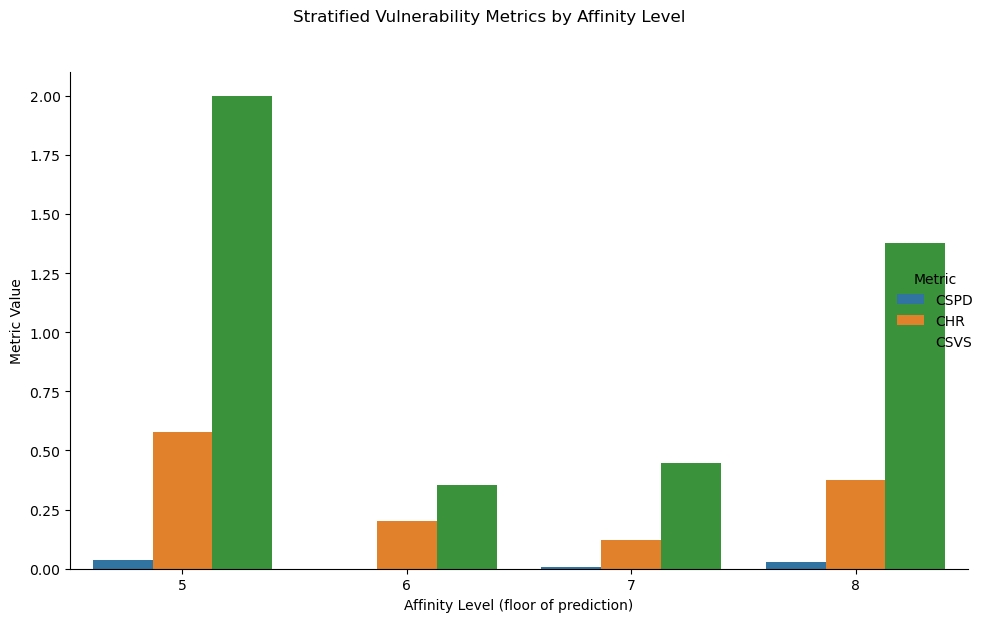

In [186]:
# Compute CSPD and CHR using affinity-level functions
CSPD_per_affinity = compute_CSPD_per_affinity_level(merged_df)
CHR_per_affinity = compute_CHR_per_affinity_level(merged_df)

# Align and normalize
common_levels = CSPD_per_affinity.index.intersection(CHR_per_affinity.index)
CSPD_abs = CSPD_per_affinity.loc[common_levels].abs()
CHR_aligned = CHR_per_affinity.loc[common_levels]

alpha = 1 / CSPD_abs.max()
beta = 1 / CHR_aligned.max()
csvs = alpha * CSPD_abs + beta * CHR_aligned
affinity_csvs = pd.Series(csvs.values, index=csvs.index, name="CSVS")


# Combine into metrics dataframe
metrics_df = pd.DataFrame({
    "Affinity_Level": CSPD_abs.index,
    "CSPD": CSPD_abs,
    "CHR": CHR_aligned,
    "CSVS": csvs
})

# Merge affinity levels into original data
#ON BLINDED PREDICTION!!!
merged_df["Affinity_Level"] = merged_df["Blinded_Prediction"].astype(int)
merged_df_with_metrics = merged_df.merge(metrics_df, on="Affinity_Level", how="left")

# Group metrics per affinity level
summary_df = (
    merged_df_with_metrics
    .dropna(subset=["CSVS", "CSPD", "CHR"])
    .groupby("Affinity_Level")[["CSPD", "CHR", "CSVS"]]
    .mean()
    .reset_index()
)

# Melt for plotting
summary_melted = summary_df.melt(
    id_vars=["Affinity_Level"],
    value_vars=["CSPD", "CHR", "CSVS"],
    var_name="Metric", value_name="Value"
)

# Plot stratified by affinity
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.catplot(
    data=summary_melted,
    kind="bar",
    x="Affinity_Level", y="Value", hue="Metric",
    height=6, aspect=1.5, ci=None
)
g.set_axis_labels("Affinity Level (floor of prediction)", "Metric Value")
g._legend.set_title("Metric")
g.fig.suptitle("Stratified Vulnerability Metrics by Affinity Level", y=1.03)
plt.tight_layout()


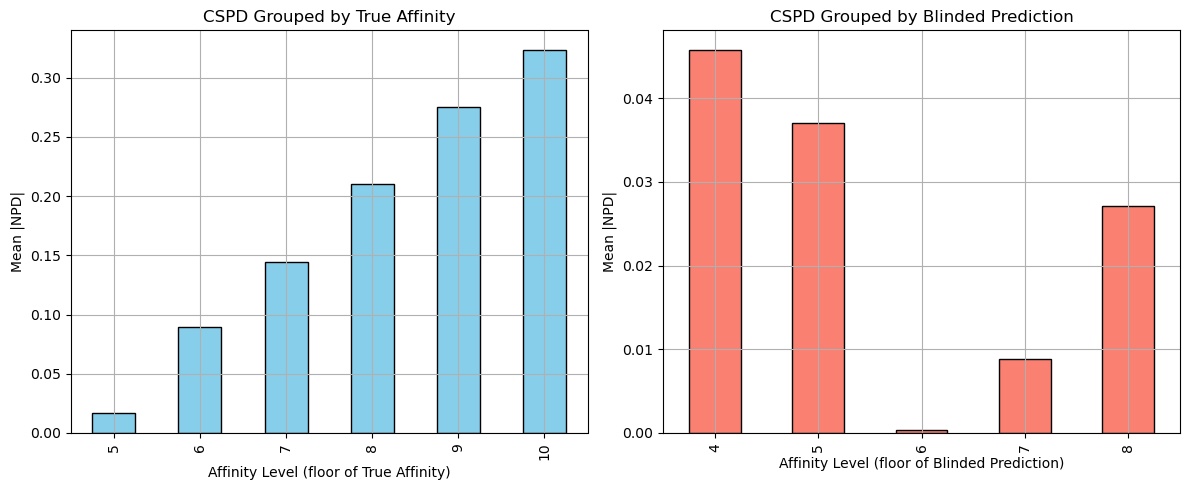

In [187]:
import pandas as pd
import matplotlib.pyplot as plt


# Compute NPD using true affinity as denominator
merged_df["NPD"] = (
    merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]
) / merged_df["True_Label"]

# Group CSPD by floored true affinity
merged_df["Affinity_Level_true"] = merged_df["True_Label"].astype(int)
cspd_true = merged_df.groupby("Affinity_Level_true")["NPD"].mean().abs()

# Group CSPD by floored blinded prediction
merged_df["Affinity_Level_blind"] = merged_df["Blinded_Prediction"].astype(int)
cspd_blind = merged_df.groupby("Affinity_Level_blind")["NPD"].mean().abs()

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cspd_true.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("CSPD Grouped by True Affinity")
plt.xlabel("Affinity Level (floor of True Affinity)")
plt.ylabel("Mean |NPD|")
plt.grid(True)

plt.subplot(1, 2, 2)
cspd_blind.plot(kind="bar", color="salmon", edgecolor="black")
plt.title("CSPD Grouped by Blinded Prediction")
plt.xlabel("Affinity Level (floor of Blinded Prediction)")
plt.ylabel("Mean |NPD|")
plt.grid(True)

plt.tight_layout()
plt.show()


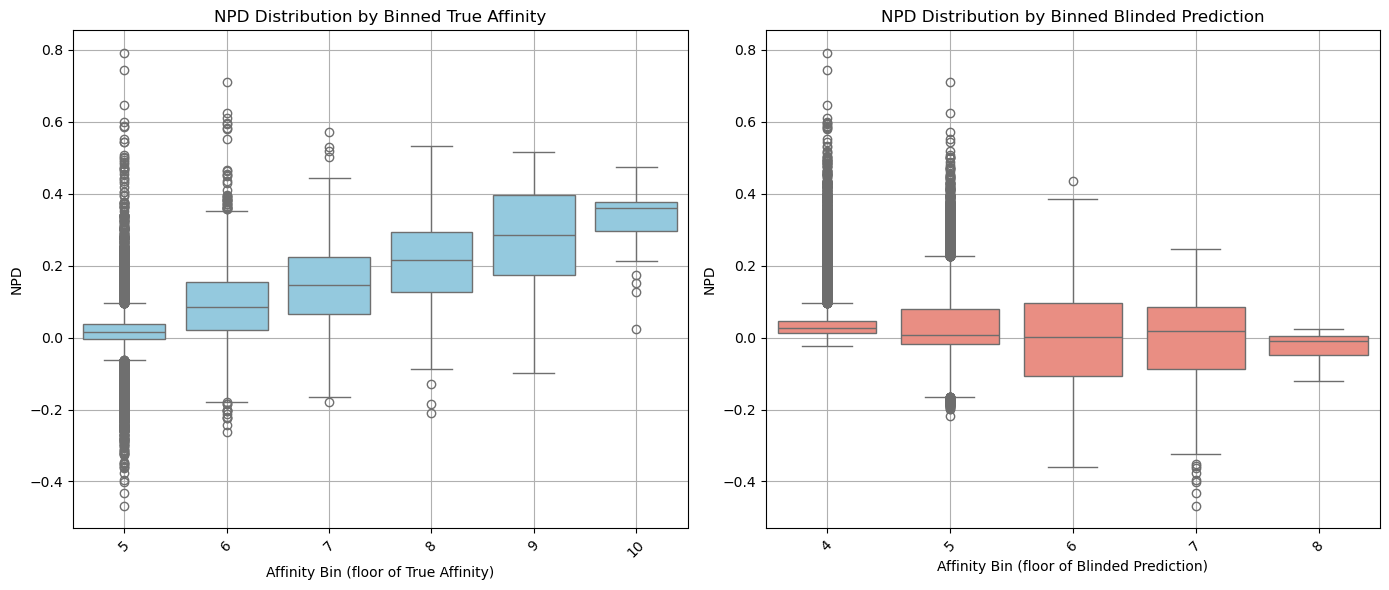

In [188]:
import numpy as np

# Create binned versions of True_Label and Blinded_Prediction
merged_df["Affinity_Bin_true"] = merged_df["True_Label"].astype(int)
merged_df["Affinity_Bin_blind"] = merged_df["Blinded_Prediction"].astype(int)

# Set up boxplots grouped by affinity bins (floored integers)
plt.figure(figsize=(14, 6))

# Boxplot grouped by binned true affinity
plt.subplot(1, 2, 1)
sns.boxplot(data=merged_df, x="Affinity_Bin_true", y="NPD", color="skyblue")
plt.title("NPD Distribution by Binned True Affinity")
plt.xlabel("Affinity Bin (floor of True Affinity)")
plt.ylabel("NPD")
plt.xticks(rotation=45)
plt.grid(True)

# Boxplot grouped by binned blinded prediction
plt.subplot(1, 2, 2)
sns.boxplot(data=merged_df, x="Affinity_Bin_blind", y="NPD", color="salmon")
plt.title("NPD Distribution by Binned Blinded Prediction")
plt.xlabel("Affinity Bin (floor of Blinded Prediction)")
plt.ylabel("NPD")
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


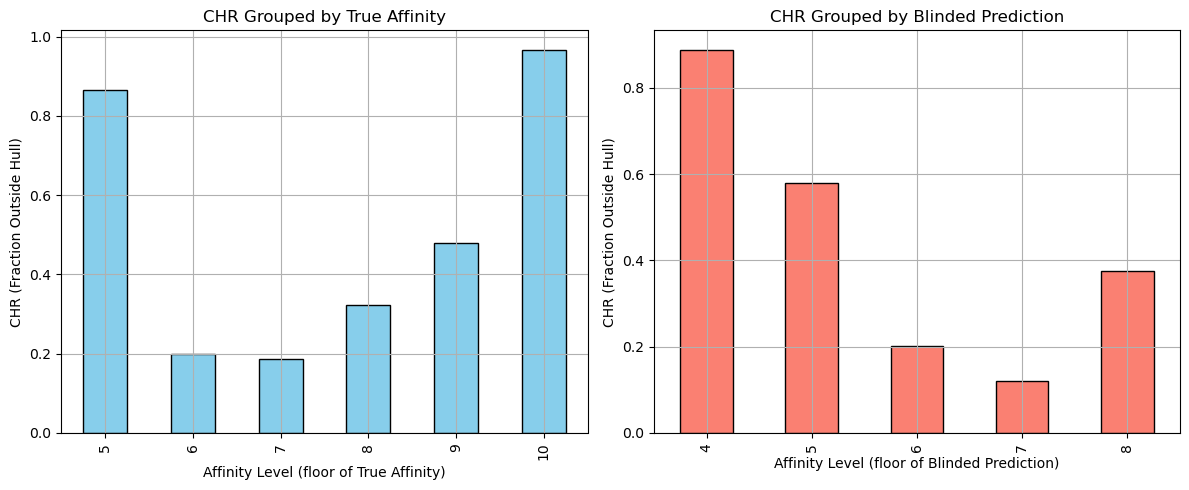

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull

# Assume merged_df is already in memory or was previously defined
# If not, this would raise an error — placeholder for now
try:
    merged_df
except NameError:
    raise ValueError("Please define or load merged_df before running this.")

def compute_CHR(merged_df, group_by_col, min_points=3):
    """
    Compute CHR stratified by either 'True_Label' or 'Blinded_Prediction' floor bins.
    """
    merged_df["Affinity_Level"] = merged_df[group_by_col].astype(int)
    CHR_dict = {}

    for level, group in merged_df.groupby("Affinity_Level"):
        if len(group) < min_points:
            continue

        points_unblinded = group[["True_Label", "Unblinded_Prediction"]].values
        points_blinded = group[["True_Label", "Blinded_Prediction"]].values

        if len(points_unblinded) < 3:
            continue  # Convex hull requires ≥3 points

        try:
            hull = ConvexHull(points_unblinded)
            polygon = Polygon(points_unblinded[hull.vertices])
            inside_mask = np.array([polygon.contains(Point(p)) for p in points_blinded])
            CHR = (~inside_mask).sum() / len(points_blinded)
            CHR_dict[level] = CHR
        except:
            continue  # Skip if hull construction fails

    return pd.Series(CHR_dict)

# Compute CHR grouped by true label and by blinded prediction
chr_true = compute_CHR(merged_df.copy(), "True_Label")
chr_blind = compute_CHR(merged_df.copy(), "Blinded_Prediction")

# Plotting comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
chr_true.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("CHR Grouped by True Affinity")
plt.xlabel("Affinity Level (floor of True Affinity)")
plt.ylabel("CHR (Fraction Outside Hull)")
plt.grid(True)

plt.subplot(1, 2, 2)
chr_blind.plot(kind="bar", color="salmon", edgecolor="black")
plt.title("CHR Grouped by Blinded Prediction")
plt.xlabel("Affinity Level (floor of Blinded Prediction)")
plt.ylabel("CHR (Fraction Outside Hull)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [190]:
import pandas as pd
import numpy as np

# === Load Pharos data ===
pharos_df = pd.read_csv("new/pharos_test_predictions_GINConvNet.csv")
pharos_df["Pred_Bin"] = pharos_df["Predicted_Value"].astype(int)

# Compute NPD
merged_df["NPD"] = (merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]) / merged_df["True_Label"]
merged_df["Affinity_Bin_blind"] = merged_df["Blinded_Prediction"].astype(int)

# --- Compute CHR Flag per point ---
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull

merged_df["CHR_Flag"] = np.nan
for level, group in merged_df.groupby("Affinity_Bin_blind"):
    if len(group) < 3:
        continue
    try:
        points_unblinded = group[["True_Label", "Unblinded_Prediction"]].values
        points_blinded = group[["True_Label", "Blinded_Prediction"]].values
        hull = ConvexHull(points_unblinded)
        polygon = Polygon(points_unblinded[hull.vertices])
        inside_mask = np.array([polygon.contains(Point(p)) for p in points_blinded])
        merged_df.loc[group.index, "CHR_Flag"] = ~inside_mask
    except:
        continue

# --- Summarize CHR and NPD per bin ---
chr_stats = merged_df.groupby("Affinity_Bin_blind")["CHR_Flag"].mean().rename("CHR")
npd_stats = merged_df.groupby("Affinity_Bin_blind")["NPD"].agg([
    ("NPD_Mean", "mean"),
    ("NPD_Std", "std"),
    ("NPD_Q1", lambda x: x.quantile(0.25)),
    ("NPD_Q3", lambda x: x.quantile(0.75)),
])

# Merge summary table
bin_summary = pd.concat([chr_stats, npd_stats], axis=1)

# --- Annotate Pharos points with estimated vulnerability ---
pharos_df = pharos_df.merge(bin_summary, how="left", left_on="Pred_Bin", right_index=True)

# Optional: display or export results
print(pharos_df[["Drug_ID", "Protein_ID", "Predicted_Value", "Pred_Bin", "CHR", "NPD_Mean", "NPD_Std", "NPD_Q1", "NPD_Q3"]].head())
# pharos_df.to_csv("pharos_with_estimated_vulnerability.csv", index=False)


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_4768/533540381.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.loc[group.index, "CHR_Flag"] = ~inside_mask


  Drug_ID Protein_ID  Predicted_Value  Pred_Bin       CHR  NPD_Mean   NPD_Std  \
0    5280     Q86TW2         5.865087         5  0.580057   0.03704  0.100243   
1    1499     P59539         5.602296         5  0.580057   0.03704  0.100243   
2    1499     P59542         5.612425         5  0.580057   0.03704  0.100243   
3    1499     Q7RTR8         5.651891         5  0.580057   0.03704  0.100243   
4    1499     Q9NYW1         5.549142         5  0.580057   0.03704  0.100243   

     NPD_Q1    NPD_Q3  
0 -0.018097  0.079469  
1 -0.018097  0.079469  
2 -0.018097  0.079469  
3 -0.018097  0.079469  
4 -0.018097  0.079469  


So that is giving same npd/chr to every predicted affinity maybe i can then incorporate protein level info to create some seperation?

Model-level CSVS: 1.0446
5    2.000000
6    0.354915
7    0.445510
8    1.377814
dtype: float64


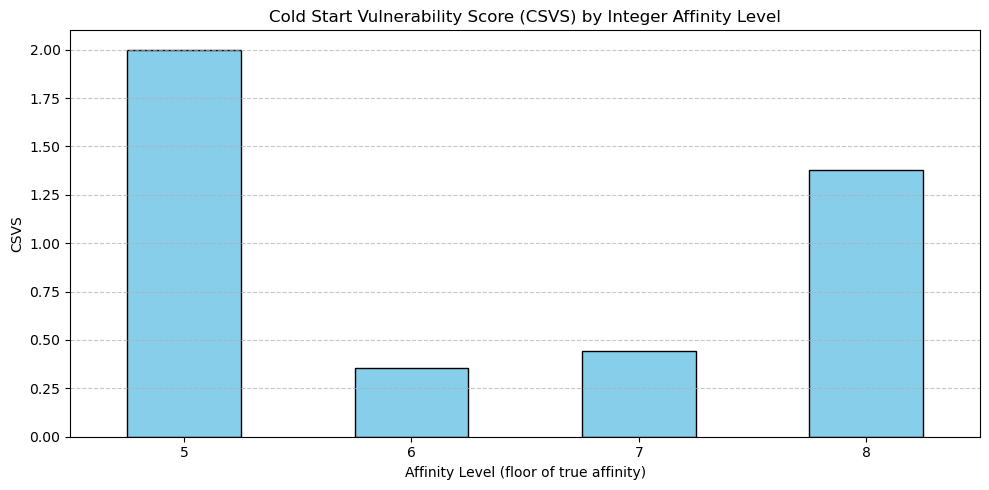

In [191]:
import matplotlib.pyplot as plt
csvs_model, csvs_per_level, alpha_used, beta_used = compute_CSVS_affinity_level(merged_df)


print(f"Model-level CSVS: {csvs_model:.4f}")
print(csvs_per_level)

# Plot CSVS per integer affinity level
csvs_per_level.sort_index().plot(
    kind='bar',
    figsize=(10, 5),
    title="Cold Start Vulnerability Score (CSVS) by Integer Affinity Level",
    color='skyblue',
    edgecolor='black'
)

plt.ylabel("CSVS")
plt.xlabel("Affinity Level (floor of true affinity)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


If I only had my model’s prediction for a new drug–protein pair, can I estimate how risky that prediction is (CSVS) — and does that risk correlate with how wrong I actually am?

In [192]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Training data
X = np.array([5, 6, 7, 8,9,10]).reshape(-1, 1)
y = np.array([1.065899, 0.550373, 0.792733, 1.051455, 1.402107, 2.000000])

#y = np.array([1.351978, 0.863145, 0.757958, 1.530269])

# Fit a polynomial model
model = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
model.fit(X, y)



Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('linearregression', LinearRegression())])

Best fit polynomial of degree 1:
 
-3.675 x + 4.494
R² of the fit: 0.1712


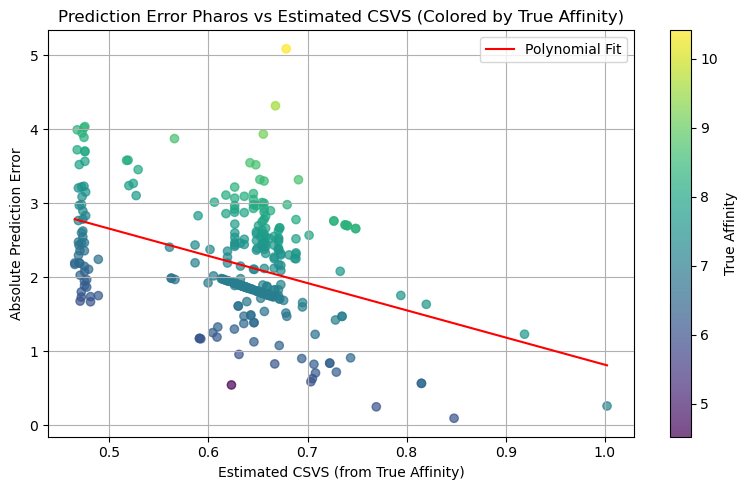

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

pharos_file = "new/pharos_test_predictions_GINConvNet.csv"
pharos_df = pd.read_csv(pharos_file)

# PREDICT USING THE PREDICTION NOT THE TRUE LABEL SINCE THAT WOULD BE UNREALISTIC
#pharos_df["Estimated_CSVS"] = model.predict(pharos_df["True_Label"].values.reshape(-1, 1))
pharos_df["Estimated_CSVS"] = model.predict(pharos_df["Predicted_Value"].values.reshape(-1, 1))
# Compute absolute prediction error
pharos_df["Abs_Error"] = np.abs(pharos_df["True_Label"] - pharos_df["Predicted_Value"])

# Fit polynomial
degree = 1  
x = pharos_df["Estimated_CSVS"]
y = pharos_df["Abs_Error"]
c = pharos_df["True_Label"]
coeffs = np.polyfit(x, y, degree)
poly_eq = np.poly1d(coeffs)

# Predict y-values from the model
y_pred = poly_eq(x)

# Compute and print R²
r_squared = r2_score(y, y_pred)
print(f"Best fit polynomial of degree {degree}:")
print(poly_eq)
print(f"R² of the fit: {r_squared:.4f}")

# Plotting
plt.figure(figsize=(8, 5))
sc = plt.scatter(x, y, c=c, cmap='viridis', alpha=0.7)
cbar = plt.colorbar(sc)
cbar.set_label('True Affinity')

x_vals = np.linspace(x.min(), x.max(), 200)
y_vals = poly_eq(x_vals)
plt.plot(x_vals, y_vals, color='red', label='Polynomial Fit')

plt.xlabel("Estimated CSVS (from True Affinity)")
plt.ylabel("Absolute Prediction Error")
plt.title("Prediction Error Pharos vs Estimated CSVS (Colored by True Affinity)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Drug?

In [194]:
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull

def compute_CHR_per_drug(merged_df):
    #based on convex hull:  how often the model predicts out-of-distribution values when faced with a cold-start protein.
    CHR_dict = {}

    for drug_id, group in merged_df.groupby("Drug_ID"):
        points_unblinded = group[["True_Label", "Unblinded_Prediction"]].values
        points_blinded = group[["True_Label", "Blinded_Prediction"]].values

        if len(points_unblinded) < 3:
            print("<3")
            continue  # Need at least 3 points for a convex hull

        try:
            hull = ConvexHull(points_unblinded)
            polygon = Polygon(points_unblinded[hull.vertices])

            inside_mask = np.array([polygon.contains(Point(p)) for p in points_blinded])
            outside_count = (~inside_mask).sum()
            CHR = outside_count / len(points_blinded)
            CHR_dict[drug_id] = CHR
        except Exception as e:
            print(f"[EXCEPTION] Protein: {protein_id} — {str(e)}")
            continue

    return pd.Series(CHR_dict)


def compute_CSPD_per_drug(merged_df):
    #how much a model’s prediction changes for the same input when the protein is blinded
    merged_df["NPD"] = (
        merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]
    ) / merged_df["True_Label"]

    CSPD = merged_df.groupby("Drug_ID")["NPD"].mean()
    return CSPD.rename("CSPD")


def compute_CSVS_drug_level(merged_df, alpha=None, beta=None):
    # Step 1: Get per-protein CSPD and CHR
    CSPD_per_drug = compute_CSPD_per_drug(merged_df)
    CHR_per_drug = compute_CHR_per_drug(merged_df)

    # Align proteins
    common_drugs = CSPD_per_drug.index.intersection(CHR_per_drug.index)
    CSPD = CSPD_per_drug.loc[common_drugs].abs()
    CHR = CHR_per_drug.loc[common_drugs]

    # Normalize weights if not provided
    if alpha is None:
        alpha = 1 / CSPD.max()
    if beta is None:
        beta = 1 / CHR.max()

    # Compute CSVS for each protein
    csvs_per_drug = alpha * CSPD + beta * CHR
    print(csvs_per_drug)

    # Return the protein-level CSVS (mean across proteins)
    csvs_model = csvs_per_drug.mean()
    return csvs_model, csvs_per_drug, alpha, beta



In [195]:
import pandas as pd
import numpy as np
import os
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

from tqdm import tqdm

def atom_features(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na','Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb','Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H','Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr','Cr', 'Pt', 'Hg', 'Pb', 'Unknown']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    [atom.GetIsAromatic()])

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    
    c_size = mol.GetNumAtoms()
    
    features = []
    for atom in mol.GetAtoms():
        feature = atom_features(atom)
        features.append( feature / sum(feature) )

    edges = []
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    g = nx.Graph(edges).to_directed()
    edge_index = []
    for e1, e2 in g.edges:
        edge_index.append([e1, e2])
        
    return c_size, features, edge_index

# import pandas as pd

# Load DAVIS drug and protein sequences
davis_drugs = pd.read_csv("davis_b3_drugs.csv")

# Load PHAROS sequences (already matched)
pharos_df = pd.read_csv("pharos_with_ids.csv")
davis_df = pd.concat([
    pd.read_csv("../data/davis_b3_test.csv"),
    pd.read_csv("../data/davis_b3_train.csv")
], ignore_index=True)
davis_df["drug_id"] = davis_df["drug_id"].astype(str).str.strip()
davis_drugs["drug_id"] = davis_drugs["drug_id"].astype(str).str.strip()

davis_drug_ids = set(davis_df["drug_id"])
pharos_drug_ids = set(pharos_df["drug_id"])

# Filter DAVIS drugs to only those used in davis_df
filtered_davis_drugs = davis_drugs[davis_drugs["drug_id"].isin(davis_drug_ids)].rename(
    columns={"drug_id": "drug", "drug_seq": "smiles"}
)[["drug", "smiles"]]
print(len(filtered_davis_drugs))

# Get PHAROS drugs
pharos_drugs = pharos_df.rename(
    columns={"drug_id": "drug", "drug_smile": "smiles"}
)[["drug", "smiles"]]
print(len(pharos_drugs))

# Combine and deduplicate
drug_smiles_dict = pd.concat([filtered_davis_drugs, pharos_drugs]) \
    .drop_duplicates("drug") \
    .set_index("drug")["smiles"] \
    .to_dict()

smile_graph = {}
for drug_id, smile in tqdm(drug_smiles_dict.items()):
    try:
        graph_data = smile_to_graph(smile)
        smile_graph[drug_id] = graph_data
    except Exception as e:
        print(f"[{drug_id}] Error: {e}")



68
495


100%|██████████| 277/277 [00:00<00:00, 1123.17it/s]


In [196]:
import sys
import os

# Add parent directory to Python path
sys.path.append(os.path.abspath(".."))


In [197]:
from models.ginconv import GINConvNet
import torch

# Instantiate model with default args (match training!)
model = GINConvNet()

# Load saved weights
model.load_state_dict(torch.load("saved_models/final_model_GINConvNet_davis_b3_1.pt", map_location="cpu"))

# Set to eval mode
model.eval()


GINConvNet(
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=78, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_feature

In [198]:
from torch_geometric.data import Data

drug_embeddings = {}

for drug_id, (num_atoms, features, edge_index) in smile_graph.items():
    x = torch.tensor(features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    batch = torch.zeros(x.shape[0], dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, batch=batch)

    with torch.no_grad():
        emb = model.extract_drug_embedding(data)
        drug_embeddings[drug_id] = emb.squeeze().numpy()


In [199]:
print(len(drug_embeddings))
# Keep only drug_ids that exist in the embeddings dict
davis_drug_embeddings = {
    did: drug_embeddings[did]
    for did in davis_drug_ids if did in drug_embeddings
}
print(len(davis_drug_embeddings))
pharos_drug_embeddings = {
    did: drug_embeddings[did]
    for did in pharos_drug_ids if did in drug_embeddings
}
print(len(pharos_drug_embeddings))

277
68
209


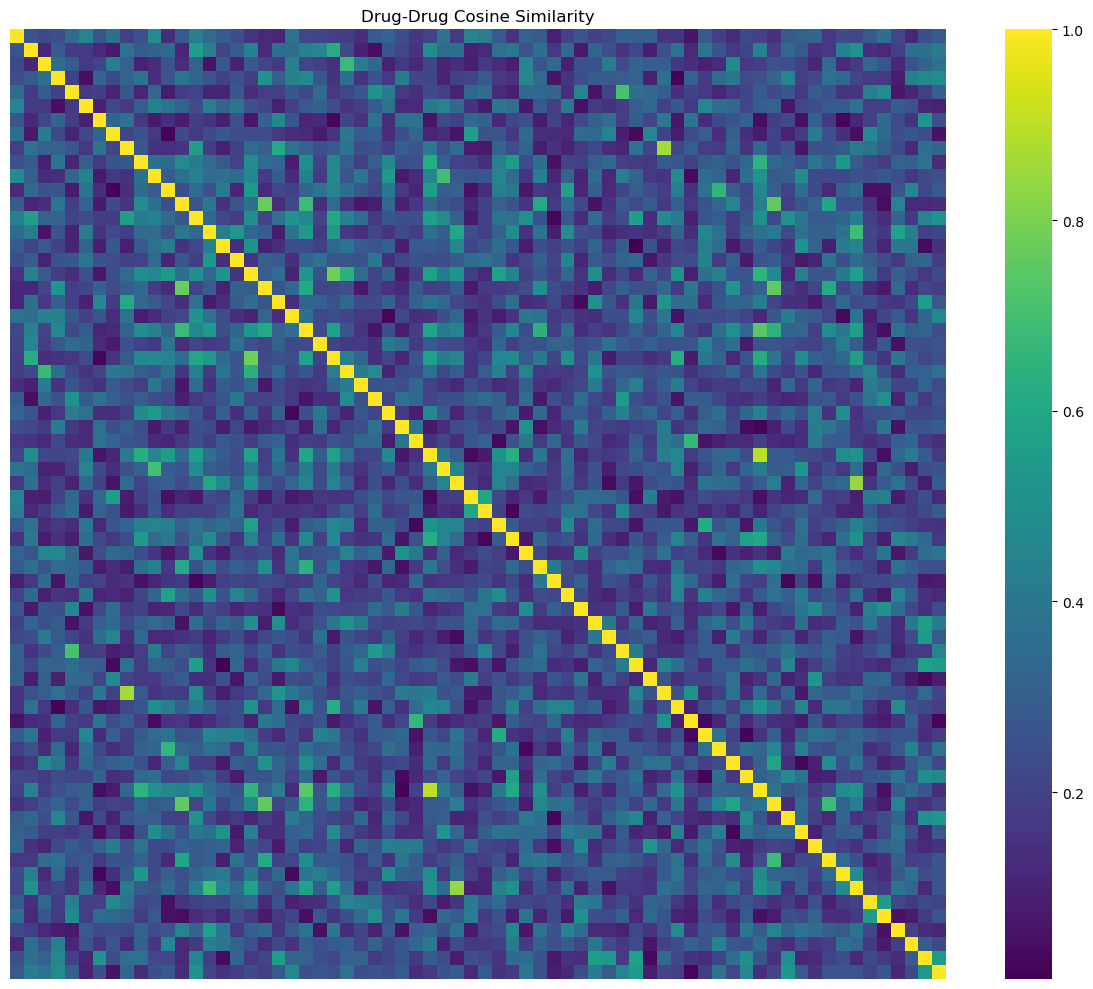

In [200]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

drug_ids = list(davis_drug_embeddings.keys())
X = np.stack([davis_drug_embeddings[did] for did in drug_ids])

similarity_matrix = cosine_similarity(X)

similarity_df = pd.DataFrame(similarity_matrix, index=drug_ids, columns=drug_ids)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title("Drug-Drug Cosine Similarity")
plt.tight_layout()
plt.show()


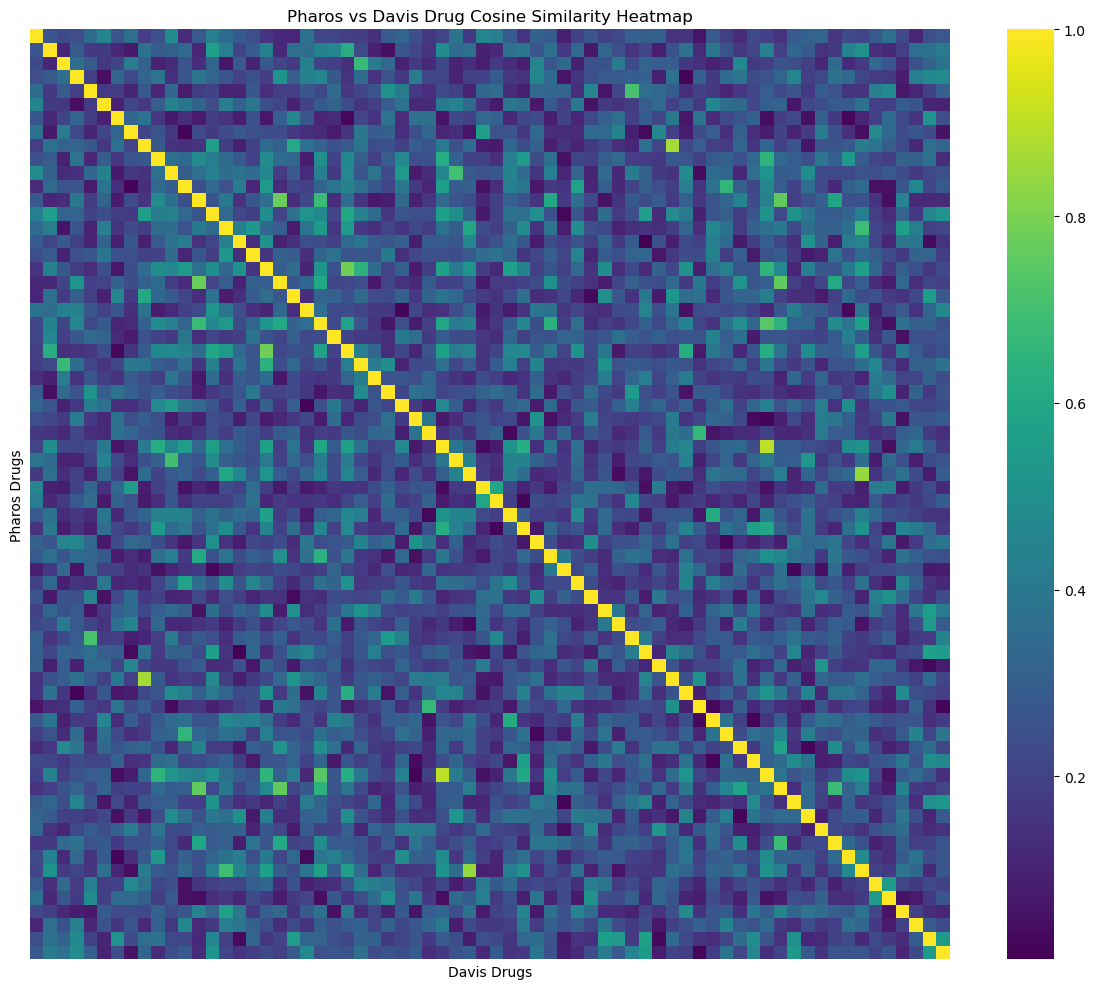

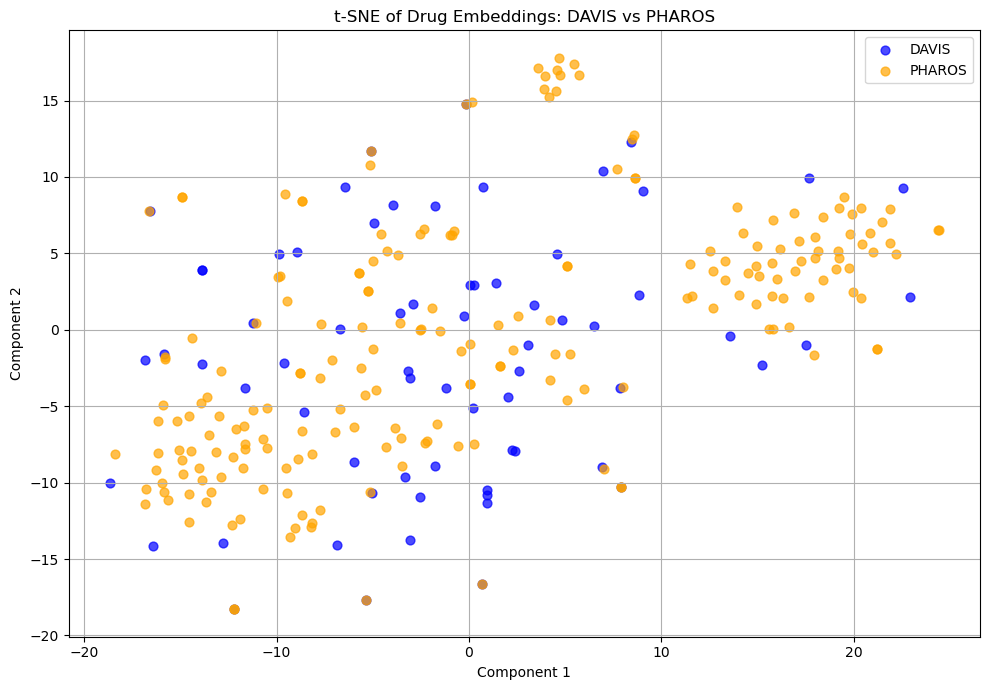

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Cosine similarity heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title("Pharos vs Davis Drug Cosine Similarity Heatmap")
plt.xlabel("Davis Drugs")
plt.ylabel("Pharos Drugs")
plt.tight_layout()
plt.show()

# t-SNE plot of combined embeddings
all_embeddings = np.vstack([X_davis, X_pharos])
labels = ["DAVIS"] * len(X_davis) + ["PHAROS"] * len(X_pharos)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
proj_2d = tsne.fit_transform(all_embeddings)

# Create plot
plt.figure(figsize=(10, 7))
colors = {"DAVIS": "blue", "PHAROS": "orange"}
for label in ["DAVIS", "PHAROS"]:
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(proj_2d[idxs, 0], proj_2d[idxs, 1], label=label, alpha=0.7, s=40, c=colors[label])

plt.title("t-SNE of Drug Embeddings: DAVIS vs PHAROS")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_4768/2840138141.py:56: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


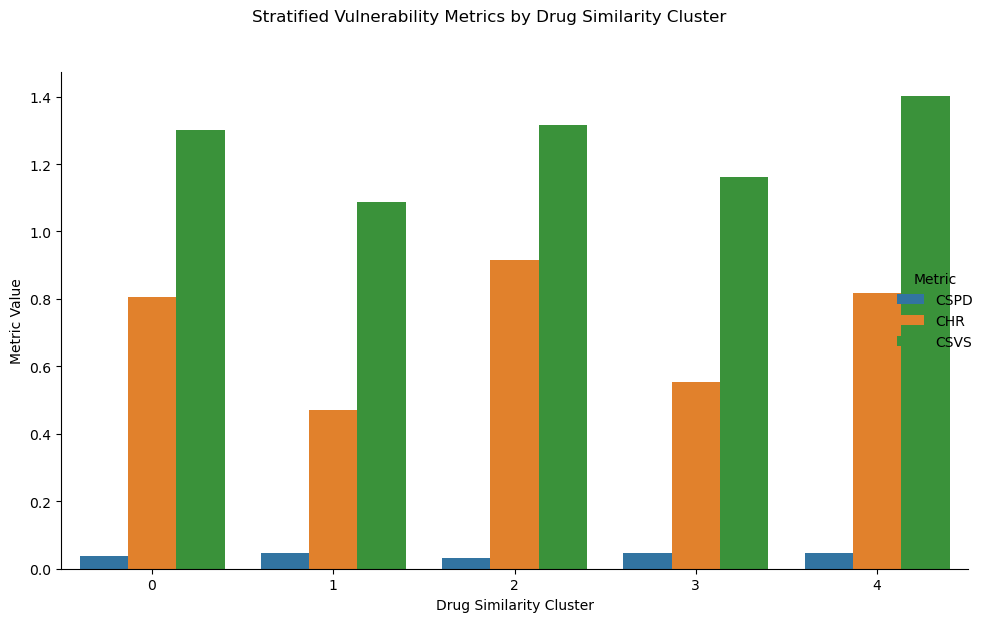

In [202]:
# Compute CSPD and CHR using your existing functions
CSPD_per_drug = compute_CSPD_per_drug(merged_df)
CSPD_abs = CSPD_per_drug.abs()
CHR_per_drug = compute_CHR_per_drug(merged_df)

# Normalize weights and compute CSVS
alpha = 1 / CSPD_abs.max()
beta = 1 / CHR_per_drug.max()
csvs = alpha * CSPD_abs + beta * CHR_per_drug
drug_csvs = pd.Series(csvs.values, index=csvs.index, name="CSVS")

# Ensure index types match for merging
CSPD_abs.index = CSPD_abs.index.astype(str)
CHR_per_drug.index = CHR_per_drug.index.astype(str)
csvs.index = csvs.index.astype(str)
merged_df["Drug_ID"] = merged_df["Drug_ID"].astype(str)

# Combine into a metrics dataframe
metrics_df = pd.DataFrame({
    "Drug_ID": CSPD_abs.index,
    "CSPD": CSPD_abs,
    "CHR": CHR_per_drug,
    "CSVS": csvs
})

# Add metrics to a new copy of merged_df
merged_df_with_metrics = merged_df.merge(metrics_df, on="Drug_ID", how="left")

# Clustering
drug_ids = merged_df_with_metrics["Drug_ID"].dropna().unique()
valid_ids = [did for did in drug_ids if did in drug_embeddings]
valid_embeddings = np.stack([drug_embeddings[did] for did in valid_ids])

kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(valid_embeddings)
cluster_map = pd.Series(clusters, index=valid_ids, name="Drug_Cluster")
cluster_df = cluster_map.rename_axis("Drug_ID").reset_index()

# Group and join with clusters
summary_df = (
    merged_df_with_metrics
    .dropna(subset=["CSVS", "CSPD", "CHR"])
    .groupby("Drug_ID")[["CSPD", "CHR", "CSVS"]]
    .mean()
    .reset_index()
    .merge(cluster_df, on="Drug_ID", how="inner")
)

# Melt and plot
summary_melted = summary_df.melt(
    id_vars=["Drug_ID", "Drug_Cluster"],
    value_vars=["CSPD", "CHR", "CSVS"],
    var_name="Metric", value_name="Value"
)

g = sns.catplot(
    data=summary_melted,
    kind="bar",
    x="Drug_Cluster", y="Value", hue="Metric",
    height=6, aspect=1.5, ci=None
)
g.set_axis_labels("Drug Similarity Cluster", "Metric Value")
g._legend.set_title("Metric")
g.fig.suptitle("Stratified Vulnerability Metrics by Drug Similarity Cluster", y=1.03)
plt.tight_layout()


In [203]:
def infer_csvs_for_pharos(pharos_df, 
                          protein_csvs, drug_csvs, affinity_csvs,
                          protein_embeddings, drug_embeddings,
                          affinity_col="predicted_affinity", top_k=5,
                          weights=(1.0, 1.0, 1.0)):  # (protein, drug, affinity)
    
    inferred_results = []

    for _, row in pharos_df.iterrows():
        pid, did, pred_aff = row["Protein_ID"], row["Drug_ID"], row[affinity_col]
        pred_aff_level = int(pred_aff)

        ### 1. Protein-level inference
        if pid in protein_embeddings and len(protein_csvs) > 0:
            known_prots = [p for p in protein_csvs.index if p in protein_embeddings]
            prot_embs = np.stack([protein_embeddings[p] for p in known_prots])
            sim_scores = cosine_similarity(
                [protein_embeddings[pid]],
                prot_embs
            )[0]
            top_idxs = np.argsort(sim_scores)[-top_k:]
            top_csvs = protein_csvs.loc[known_prots].iloc[top_idxs].values
            protein_infer = np.mean(top_csvs)
        else:
            protein_infer = np.nan

        ### 2. Drug-level inference
        
        if did in drug_embeddings and len(drug_csvs) > 0:
            known_drugs = [str(d) for d in drug_csvs.index if str(d) in drug_embeddings]
            drug_embs = np.stack([drug_embeddings[str(d)] for d in known_drugs])

            sim_scores = cosine_similarity(
                [drug_embeddings[did]],
                drug_embs
            )[0]
            top_idxs = np.argsort(sim_scores)[-top_k:]
            top_csvs = drug_csvs.loc[known_drugs].iloc[top_idxs].values
            drug_infer = np.mean(top_csvs)
        else:
            drug_infer = np.nan

        ### 3. Affinity-level inference
        affinity_infer = affinity_csvs.get(pred_aff_level, np.nan)

        ### 4. Combine (ignore NaNs in weighting)
        values = np.array([protein_infer, drug_infer, affinity_infer])
        ws = np.array(weights)
        valid_mask = ~np.isnan(values)
        if valid_mask.any():
            combined = np.average(values[valid_mask], weights=ws[valid_mask])
        else:
            combined = np.nan

        inferred_results.append({
            "Protein_ID": pid,
            "Drug_ID": did,
            "predicted_affinity": pred_aff,
            "CSVS_protein": protein_infer,
            "CSVS_drug": drug_infer,
            "CSVS_affinity": affinity_infer,
            "CSVS_combined": combined
        })

    return pd.DataFrame(inferred_results)


In [226]:
# Load your preprocessed PHAROS dataframe with predicted affinities
pharos_df = pd.read_csv("new/pharos_test_predictions_GINConvNet.csv")  # or whichever CSV contains prot_id, drug_id, predicted_affinity
print(len(drug_embeddings))

protein_csvs.index = protein_csvs.index.astype(str)
drug_csvs.index = drug_csvs.index.astype(str)
protein_embeddings = {str(k): v for k, v in protein_embeddings.items()}
drug_embeddings = {str(k): v for k, v in drug_embeddings.items()}
pharos_df["Protein_ID"] = pharos_df["Protein_ID"].astype(str)
pharos_df["Drug_ID"] = pharos_df["Drug_ID"].astype(str)


# Example call to inference function
pharos_inferred_df = infer_csvs_for_pharos(
    pharos_df=pharos_df,
    protein_csvs=protein_csvs,     # pd.Series with index = Protein_ID, value = CSVS
    drug_csvs=drug_csvs,           # pd.Series with index = Drug_ID, value = CSVS
    affinity_csvs=affinity_csvs,   # pd.Series with index = int affinity level, value = CSVS
    protein_embeddings=protein_embeddings,  # dict: Protein_ID -> np.array
    drug_embeddings=drug_embeddings,        # dict: Drug_ID -> np.array
    affinity_col="Predicted_Value",      # or whatever your affinity prediction column is named
    top_k=5,                                # Number of most similar neighbors to average
    weights=(1.0, 1.0, 1.0)                 # Relative weights for (protein, drug, affinity)
)


277


In [205]:
# Load true predictions for PHAROS
true_results = pd.read_csv("new/pharos_test_predictions_GINConvNet.csv")

# Merge with inferred CSVS values
comparison_df = (
    pharos_inferred_df
    .rename(columns={"prot_id": "Protein_ID", "drug_id": "Drug_ID"})
    .merge(true_results, on=["Drug_ID", "Protein_ID"], how="left")
)

# Compute error columns if desired
comparison_df["Abs_Error"] = np.abs(comparison_df["True_Label"] - comparison_df["Predicted_Value"])
comparison_df["Signed_Error"] = comparison_df["Predicted_Value"] - comparison_df["True_Label"]



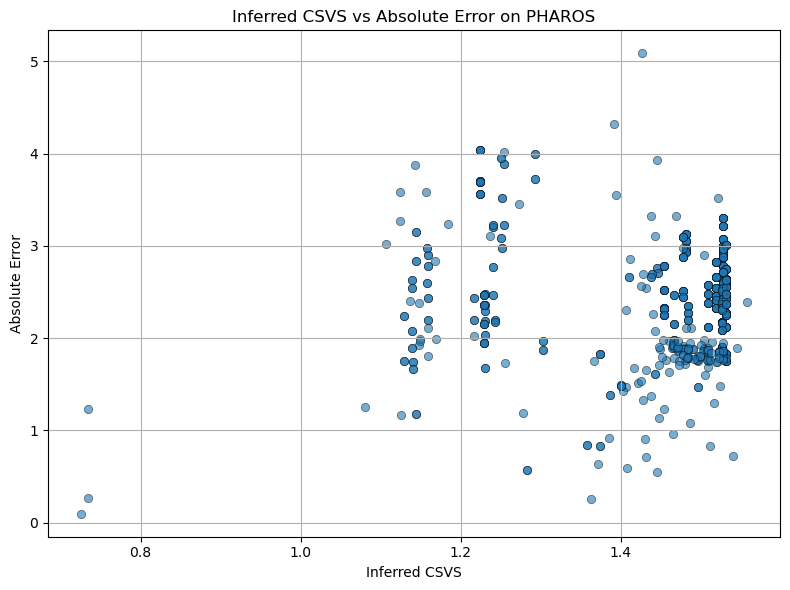

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=comparison_df, x="CSVS_combined", y="Abs_Error", alpha=0.6, edgecolor="k")
plt.xlabel("Inferred CSVS")
plt.ylabel("Absolute Error")
plt.title("Inferred CSVS vs Absolute Error on PHAROS")
plt.grid(True)
plt.tight_layout()
plt.show()


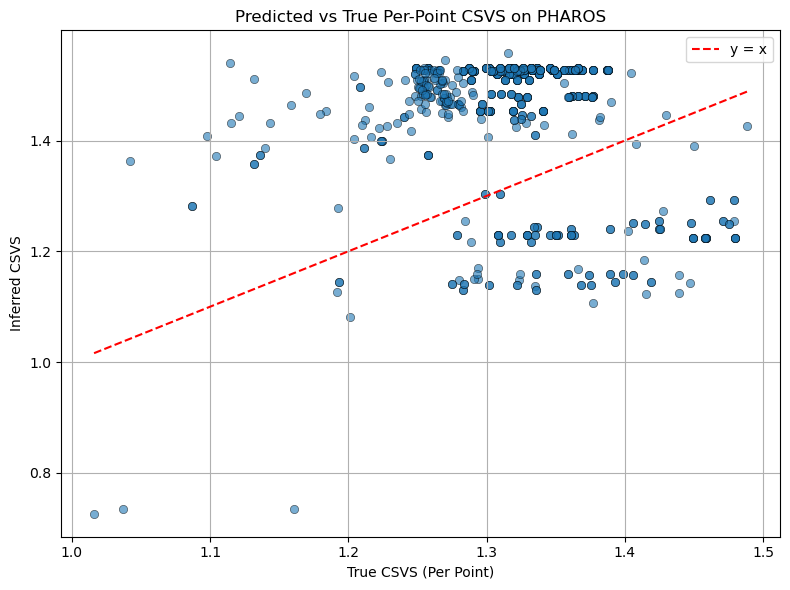

Spearman ρ = -0.042, p = 0.273


In [207]:
# Use previously computed alpha and beta
alpha = 1.0  # from your calibration on DAVIS
beta = 1.0

# Compute point-level NPD
comparison_df["NPD"] = (comparison_df["Predicted_Value"] - comparison_df["True_Label"]) / comparison_df["True_Label"]

# If you don't have per-point CHR, you can set a placeholder (e.g., 1 for all, or 0.5)
comparison_df["CHR_point"] = 1  # or more refined logic if you have it

# Compute ground-truth point-level CSVS
comparison_df["True_CSVS"] = alpha * comparison_df["NPD"].abs() + beta * comparison_df["CHR_point"]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=comparison_df,
    x="True_CSVS",
    y="CSVS_combined",
    alpha=0.6,
    edgecolor="k"
)
plt.plot([comparison_df["True_CSVS"].min(), comparison_df["True_CSVS"].max()],
         [comparison_df["True_CSVS"].min(), comparison_df["True_CSVS"].max()],
         'r--', label="y = x")
plt.xlabel("True CSVS (Per Point)")
plt.ylabel("Inferred CSVS")
plt.title("Predicted vs True Per-Point CSVS on PHAROS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from scipy.stats import spearmanr
rho, p = spearmanr(comparison_df["True_CSVS"], comparison_df["CSVS_combined"])
print(f"Spearman ρ = {rho:.3f}, p = {p:.3g}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

pharos_df = pd.read_csv("new/pharos_test_predictions_GINConvNet.csv")  
davis_df = pd.read_csv("new/concatenated_final_test_predictions.csv")

# === Ensure string IDs ===
pharos_df["Protein_ID"] = pharos_df["Protein_ID"].astype(str)
pharos_df["Drug_ID"] = pharos_df["Drug_ID"].astype(str)
davis_df["Protein_ID"] = davis_df["Protein_ID"].astype(str)
davis_df["Drug_ID"] = davis_df["Drug_ID"].astype(str)

# Make sure keys are strings:
drug_embeddings = {str(k): v for k, v in drug_embeddings.items()}
protein_embeddings = {str(k): v for k, v in protein_embeddings.items()}

# === Compute MAX_AFFINITY ===
pharos_max = pharos_df["Predicted_Value"].max()
davis_max = davis_df["Predicted_Value"].max()
MAX_AFFINITY = max(pharos_max, davis_max)

# === Build Davis reference vectors ===
ref_vecs = []
ref_ids = []  # keep triplet ID to match similarity values
for _, row in davis_df.iterrows():
    d, p, aff = row["Drug_ID"], row["Protein_ID"], row["Predicted_Value"]
    if d in drug_embeddings and p in protein_embeddings:
        vec = np.concatenate([
            drug_embeddings[d],
            protein_embeddings[p],
            [aff / MAX_AFFINITY]
        ])
        ref_vecs.append(vec)
        ref_ids.append((d, p, aff))

ref_vecs = np.stack(ref_vecs)

# === Loop through Pharos and compute similarity vectors ===
similarities_all = []

for _, row in pharos_df.iterrows():
    pid, did, pred_aff = row["Protein_ID"], row["Drug_ID"], row["Predicted_Value"]
    
    if pid not in protein_embeddings or did not in drug_embeddings:
        similarities_all.append(None)
        continue
    
    query_vec = np.concatenate([
        drug_embeddings[did],
        protein_embeddings[pid],
        [pred_aff / MAX_AFFINITY]
    ])
    
    sims = cosine_similarity([query_vec], ref_vecs)[0]
    similarities_all.append(sims)

pharos_df["similarities"] = similarities_all  # each row has an array


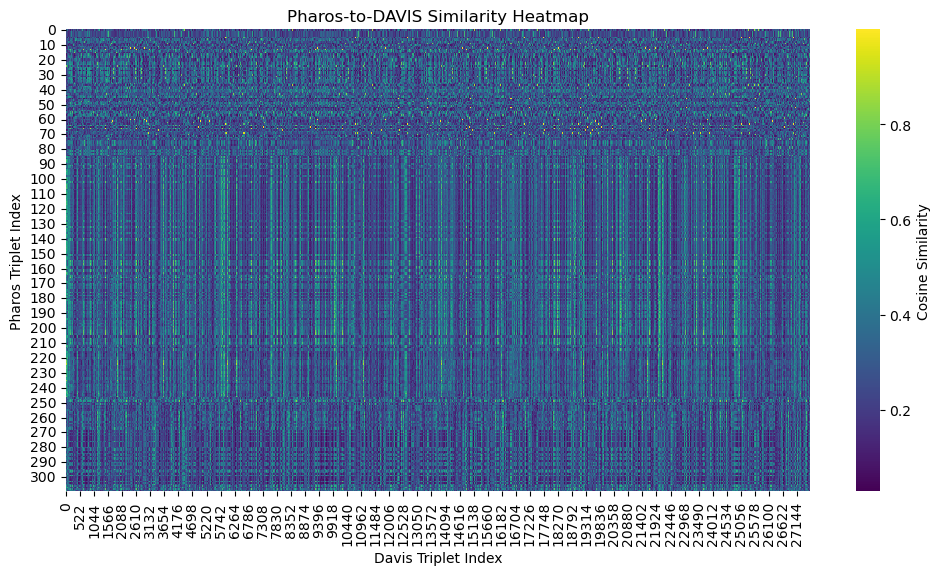

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert list of similarity vectors to matrix (n_pharos x n_davis)
similarity_matrix = np.stack([sims for sims in pharos_df["similarities"] if sims is not None])

plt.figure(figsize=(12, 6))
sns.heatmap(similarity_matrix, cmap="viridis", cbar_kws={'label': 'Cosine Similarity'})
plt.xlabel("Davis Triplet Index")
plt.ylabel("Pharos Triplet Index")
plt.title("Pharos-to-DAVIS Similarity Heatmap")
plt.show()


In [230]:
%pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 7.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 7.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


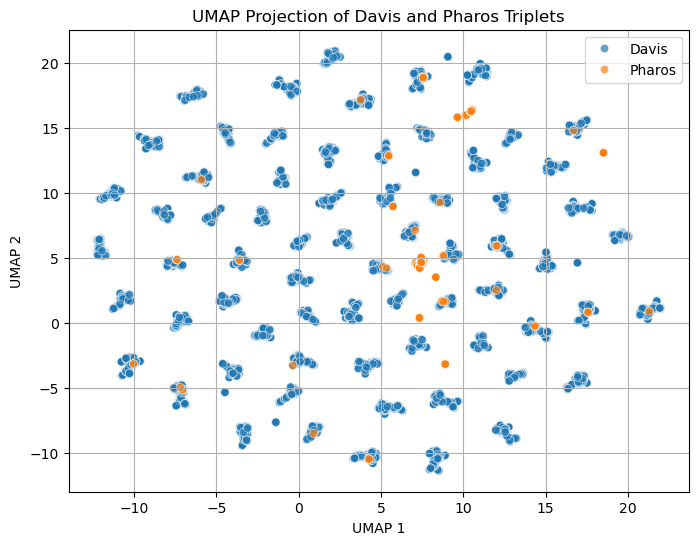

In [231]:
from umap import UMAP

# Build combined dataset of triplet vectors
pharos_vecs = []
for _, row in pharos_df.iterrows():
    pid, did, pred_aff = str(row["Protein_ID"]), str(row["Drug_ID"]), row["Predicted_Value"]
    if pid in protein_embeddings and did in drug_embeddings:
        pharos_vecs.append(np.concatenate([
            drug_embeddings[did], protein_embeddings[pid], [pred_aff / MAX_AFFINITY]
        ]))

all_vecs = np.vstack([ref_vecs] + pharos_vecs)
labels = ["Davis"] * len(ref_vecs) + ["Pharos"] * len(pharos_vecs)

# UMAP projection
umap = UMAP(random_state=42)
umap_proj = umap.fit_transform(all_vecs)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_proj[:, 0], y=umap_proj[:, 1], hue=labels, alpha=0.7)
plt.title("UMAP Projection of Davis and Pharos Triplets")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.grid(True)
plt.show()


CSVs = Prediction Error (cspd) + Hull Risk(signed dist from hull) + Conformity Penalty ( )

can scale predictions and trues to 0 to 1 or rank based since they prob have quite different ranges

In [320]:
from scipy.spatial import ConvexHull, Delaunay
from shapely.geometry import Polygon, Point

def compute_signed_distance_and_direction_to_hull(polygon, delaunay, point):
    """
    Compute signed distance and direction vector from a point to the convex hull boundary.
    
    Returns:
        signed_distance (float): Negative if inside the hull, positive if outside
        direction_vector (np.array): Unit vector from closest hull point to the point
    """
    shapely_point = Point(point)
    boundary = polygon.exterior
    nearest = boundary.interpolate(boundary.project(shapely_point))
    vec = np.array(point) - np.array([nearest.x, nearest.y])
    mag = np.linalg.norm(vec)

    if polygon.contains(shapely_point) or polygon.touches(shapely_point):
        signed_dist = -mag
    else:
        signed_dist = mag

    direction = vec / mag if mag > 1e-8 else np.array([0.0, 0.0])
    return signed_dist, direction

def compute_vulnerability_fractions_from_arrays(unblinded, blinded):
    """
    Compute conformity-based vulnerability using signed distances to the convex hull.
    Points inside the hull get negative distances; outside get positive.
    """
    # Construct convex hull polygon and Delaunay triangulation for inclusion checks
    hull = ConvexHull(unblinded)
    polygon = Polygon(unblinded[hull.vertices])
    delaunay = Delaunay(unblinded[hull.vertices])

    # Compute signed distances for each point
    dists_unblinded = np.array([
        compute_signed_distance_to_hull(polygon, delaunay, p) for p in unblinded
    ])
    dists_blinded = np.array([
        compute_signed_distance_to_hull(polygon, delaunay, p) for p in blinded
    ])

    # Add small epsilon to prevent equal-value ties
    epsilon = 1e-8
    top_fractions = np.array([
        np.sum(dists_unblinded < du - epsilon) / len(dists_unblinded)
        for du in dists_unblinded
    ])
    bottom_fractions = np.array([
        np.sum(dists_unblinded < db - epsilon) / len(dists_unblinded)
        for db in dists_blinded
    ])

    return top_fractions, bottom_fractions, dists_blinded, dists_unblinded


def compute_csvs_scores_pharos(
    df_blinded,
    df_unblinded,
    true_col="True_Label",
    pred_col="Predicted_Value",
    normalize="rank",  # options: "rank", "minmax", or None
    include_signed_d=True
):
    """
    Compute CSVS = Prediction Error + Hull Risk (NO Conformity Penalty)
    Parameters:
        df_blinded (pd.DataFrame): Blinded predictions (e.g. Pharos)
        df_unblinded (pd.DataFrame): Unblinded reference set (e.g. DAVIS)
        true_col (str): Column for true affinity
        pred_col (str): Column for predicted affinity
        normalize (str): Method for normalization of true/predicted values
        include_signed_d (bool): Whether to include signed hull distance
    """
    df = df_blinded.copy()

    # CSPD: scaled absolute error
    df["CSPD"] = np.abs(
        (df["True_Label"] - df["Predicted_Value"]) /
        (merged["True_Label"] + 1e-8)
    )

    # Convex hull risk using (true_norm, pred_norm)
    unblinded_points = df_unblinded[["True_Label", "Predicted_Value"]].values
    blinded_points = df[["True_Label", "Predicted_Value"]].values

    hull = ConvexHull(unblinded_points)
    polygon = Polygon(unblinded_points[hull.vertices])
    delaunay = Delaunay(unblinded_points[hull.vertices])

    # Compute signed distances and direction vectors
    signed_dists, direction_vecs = zip(*[
        compute_signed_distance_and_direction_to_hull(polygon, delaunay, pt)
        for pt in blinded_points
    ])

    # Convert to arrays
    signed_dists = np.array(signed_dists)
    direction_vecs = np.array(direction_vecs)

    # Assign to dataframe
    df["HullDist"] = signed_dists if include_signed_d else np.abs(signed_dists)
    df["delta_vec"] = list(direction_vecs)

    # Final CSVS score
    df["CSVS"] = df["CSPD"] + df["HullDist"]
        
    columns = [
            "Protein_ID", "Drug_ID", true_col, pred_col,
            "CSPD", "HullDist", "delta_vec", "CSVS"
        ]

    return df[columns]

In [321]:
def compute_csvs_scores_davis(
    df_blinded,
    df_unblinded,
    is_davis=True,
    true_col="True_Label",
    pred_col="Predicted_Value",
    normalize="rank",  # options: "rank", "minmax", or None
    include_signed_d=True
):
    """
    Compute CSVS = Prediction Deviation (CSPD) + Convex Hull Risk (HullDist)
    Optionally adds conformity-based metrics for DAVIS.

    Parameters:
        df_blinded (pd.DataFrame): Blinded predictions (e.g. Pharos)
        df_unblinded (pd.DataFrame): Unblinded reference set (e.g. DAVIS)
        true_col (str): Column for true affinity
        pred_col (str): Column for predicted affinity
        normalize (str): Method for normalization of true/predicted values
        include_signed_d (bool): Whether to include signed hull distance
    """
    df = df_blinded.copy()
    df_unblinded = df_unblinded.rename(columns={pred_col: "Unblinded_Prediction"})
    df = df.rename(columns={pred_col: "Blinded_Prediction"})

    # Merge to bring Unblinded_Prediction into df
    merged = pd.merge(
        df_unblinded[["Drug_ID", "Protein_ID", true_col, "Unblinded_Prediction"]],
        df[["Drug_ID", "Protein_ID", true_col, "Blinded_Prediction"]],
        on=["Drug_ID", "Protein_ID", true_col]
    )
    merged["CSPD"] = np.abs(
        (merged["Unblinded_Prediction"] - merged["Blinded_Prediction"]) /
        (merged[true_col] + 1e-8)
    )

    # Bring CSPD and Unblinded_Prediction back into df
    df = pd.merge(
        df,
        merged[["Drug_ID", "Protein_ID", true_col, "Blinded_Prediction", "Unblinded_Prediction", "CSPD"]],
        on=["Drug_ID", "Protein_ID", true_col, "Blinded_Prediction"],
        how="left"
    )

    # Convex hull risk using (true, prediction) pairs from DAVIS
    unblinded_points = df_unblinded[[true_col, "Unblinded_Prediction"]].values
    blinded_points = df[[true_col, "Blinded_Prediction"]].values

    hull = ConvexHull(unblinded_points)
    polygon = Polygon(unblinded_points[hull.vertices])
    delaunay = Delaunay(unblinded_points[hull.vertices])

    # Signed distances to the hull
    signed_dists, direction_vecs = zip(*[
        compute_signed_distance_and_direction_to_hull(polygon, delaunay, pt)
        for pt in blinded_points
    ])
    df["HullDist"] = np.array(signed_dists) if include_signed_d else np.abs(signed_dists)
    df["delta_vec"] = list(direction_vecs)

    if is_davis:
        dists_unblinded = np.array([
            compute_signed_distance_and_direction_to_hull(polygon, delaunay, pt)[0]
            for pt in unblinded_points
        ])
        
        epsilon = 1e-8

        # Compute distances for conformity metrics
        df["unblinded_dist"] = df.apply(
            lambda row: compute_signed_distance_and_direction_to_hull(
                polygon, delaunay, [row[true_col], row["Unblinded_Prediction"]])[0],
            axis=1
        )
        df["blinded_dist"] = df.apply(
            lambda row: compute_signed_distance_and_direction_to_hull(
                polygon, delaunay, [row[true_col], row["Blinded_Prediction"]])[0],
            axis=1
        )
        df["top_fraction"] = df["unblinded_dist"].apply(
            lambda d: np.sum(dists_unblinded < d - epsilon) / len(dists_unblinded)
        )
        df["bottom_fraction"] = df["blinded_dist"].apply(
            lambda d: np.sum(dists_unblinded < d - epsilon) / len(dists_unblinded)
        )
        df["conformity_score"] = df["bottom_fraction"] - df["top_fraction"]

    # Final CSVS score (can later weight CSPD or HullDist differently)
    df["CSVS"] = df["CSPD"] + df["HullDist"]

    columns = [
        "Protein_ID", "Drug_ID", true_col, "Blinded_Prediction",
        "CSPD", "HullDist", "delta_vec", "CSVS"
    ]
    if is_davis:
        columns += ["Unblinded_Prediction", "unblinded_dist", "blinded_dist",
                    "top_fraction", "bottom_fraction", "conformity_score"]

    return df[columns]


# remember you dont need a vulnerability score for the pharos points?

can do normalized prediction err + dist from hull for pharos since cspd doesmt apply to pharos

In [322]:
# Load full DataFrames
pharos_df = pd.read_csv("new/pharos_test_predictions_GINConvNet.csv")
blinded_df = pd.read_csv("new/concatenated_final_test_predictions.csv")
unblinded_df = pd.read_csv("new/crossval_predictions_GINConvNet_davis_b3.csv")

# Make sure columns are consistent
pharos_df["Protein_ID"] = pharos_df["Protein_ID"].astype(str)
pharos_df["Drug_ID"] = pharos_df["Drug_ID"].astype(str)
blinded_df["Protein_ID"] = blinded_df["Protein_ID"].astype(str)
blinded_df["Drug_ID"] = blinded_df["Drug_ID"].astype(str)
unblinded_df["Protein_ID"] = unblinded_df["Protein_ID"].astype(str)
unblinded_df["Drug_ID"] = unblinded_df["Drug_ID"].astype(str)

# Compute CSVS scores
from typing import Literal

pharos_with_csvs = compute_csvs_scores_pharos(
    df_blinded=pharos_df,
    df_unblinded=unblinded_df,
    true_col="True_Label",
    pred_col="Predicted_Value",
    normalize="rank"
)

davis_with_csvs = compute_csvs_scores_davis(
    df_blinded=blinded_df,
    df_unblinded=unblinded_df,
    is_davis=True,
    true_col="True_Label",
    pred_col="Predicted_Value",
    normalize="rank"
)
print(davis_with_csvs.columns)

Index(['Protein_ID', 'Drug_ID', 'True_Label', 'Blinded_Prediction', 'CSPD',
       'HullDist', 'delta_vec', 'CSVS', 'Unblinded_Prediction',
       'unblinded_dist', 'blinded_dist', 'top_fraction', 'bottom_fraction',
       'conformity_score'],
      dtype='object')


In [323]:
print(pharos_with_csvs.columns)
# print(pharos_with_csvs.head)
print(pharos_with_csvs["CSVS"].max())
print(pharos_with_csvs["HullDist"].max())
print(pharos_with_csvs["CSPD"].max())

Index(['Protein_ID', 'Drug_ID', 'True_Label', 'Predicted_Value', 'CSPD',
       'HullDist', 'delta_vec', 'CSVS'],
      dtype='object')
1.143024654855284
0.623225645115439
0.5254838534824429


In [250]:

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_csvs_metrics(df, label="Dataset"):
    """
    Visualizes CSVS metrics: CSPD, HullDist, and CSVS as histograms and boxplots.

    Parameters:
        df (pd.DataFrame): DataFrame containing CSPD, HullDist, and CSVS columns
        label (str): Name of the dataset (e.g., "Pharos", "Davis") for titles
    """
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))

    metrics = ["CSPD", "HullDist", "CSVS"]
    for i, metric in enumerate(metrics):
        # Histogram
        sns.histplot(df[metric], bins=30, ax=axes[i, 0], kde=True, color="skyblue")
        axes[i, 0].set_title(f"{metric} Histogram ({label})")
        axes[i, 0].set_xlabel(metric)
        axes[i, 0].set_ylabel("Frequency")

        # Boxplot
        sns.boxplot(x=df[metric], ax=axes[i, 1], color="lightcoral")
        axes[i, 1].set_title(f"{metric} Boxplot ({label})")
        axes[i, 1].set_xlabel(metric)

    plt.tight_layout()
    plt.show()


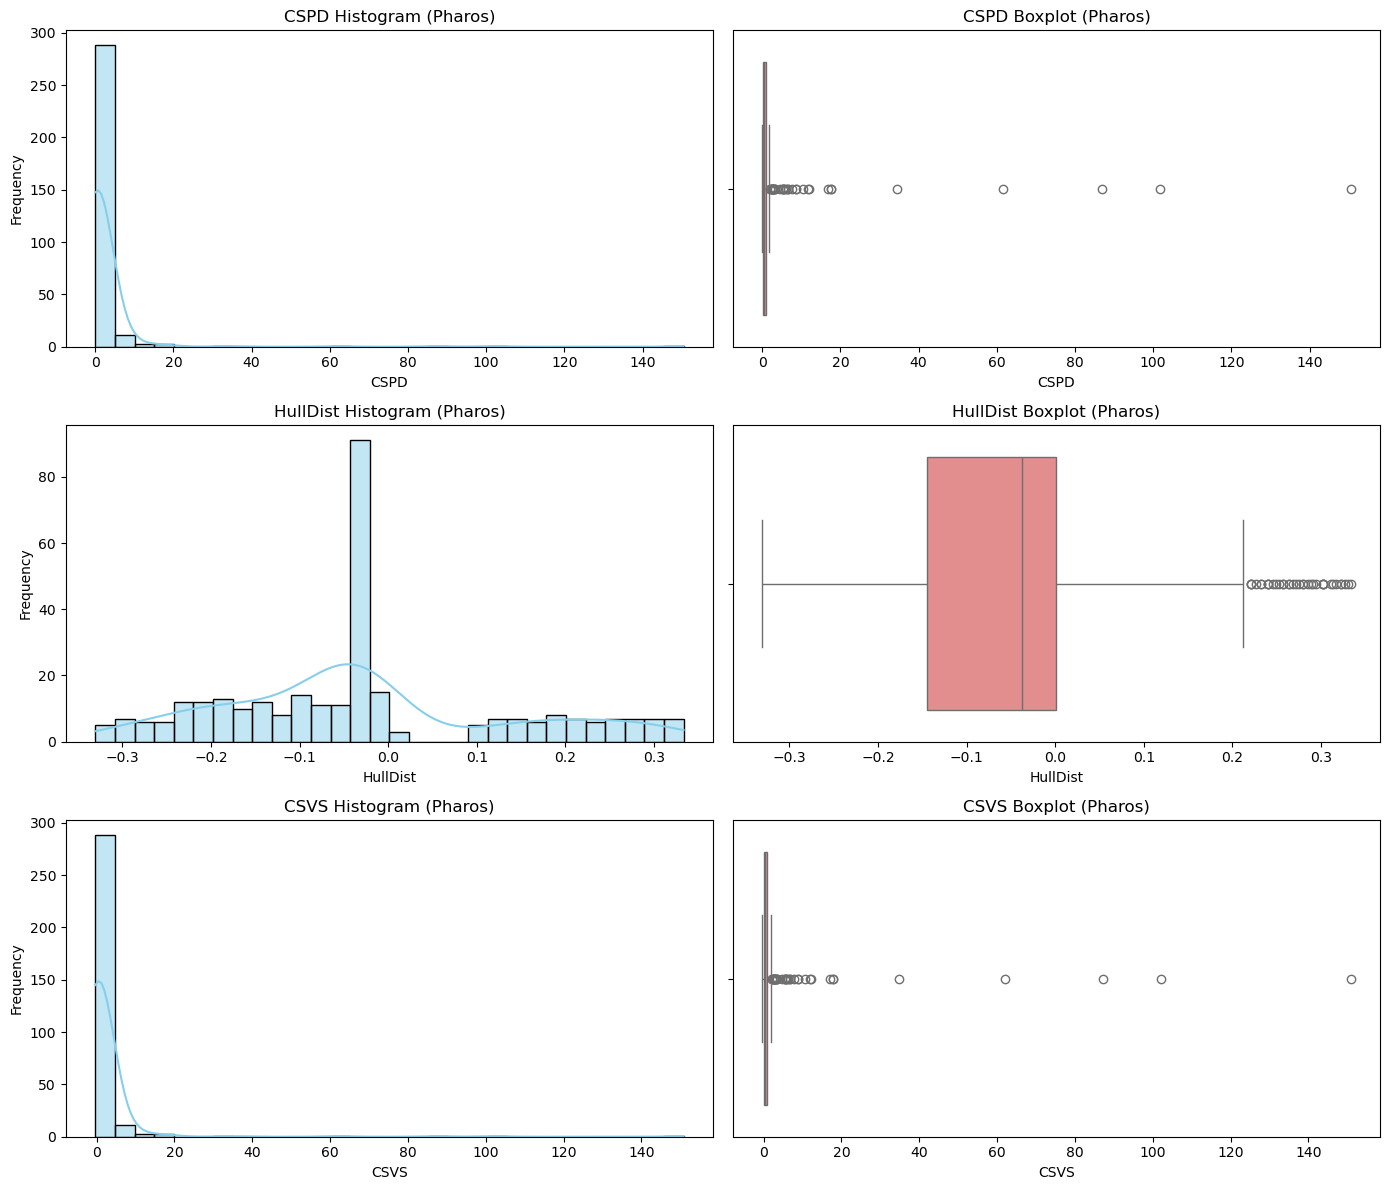

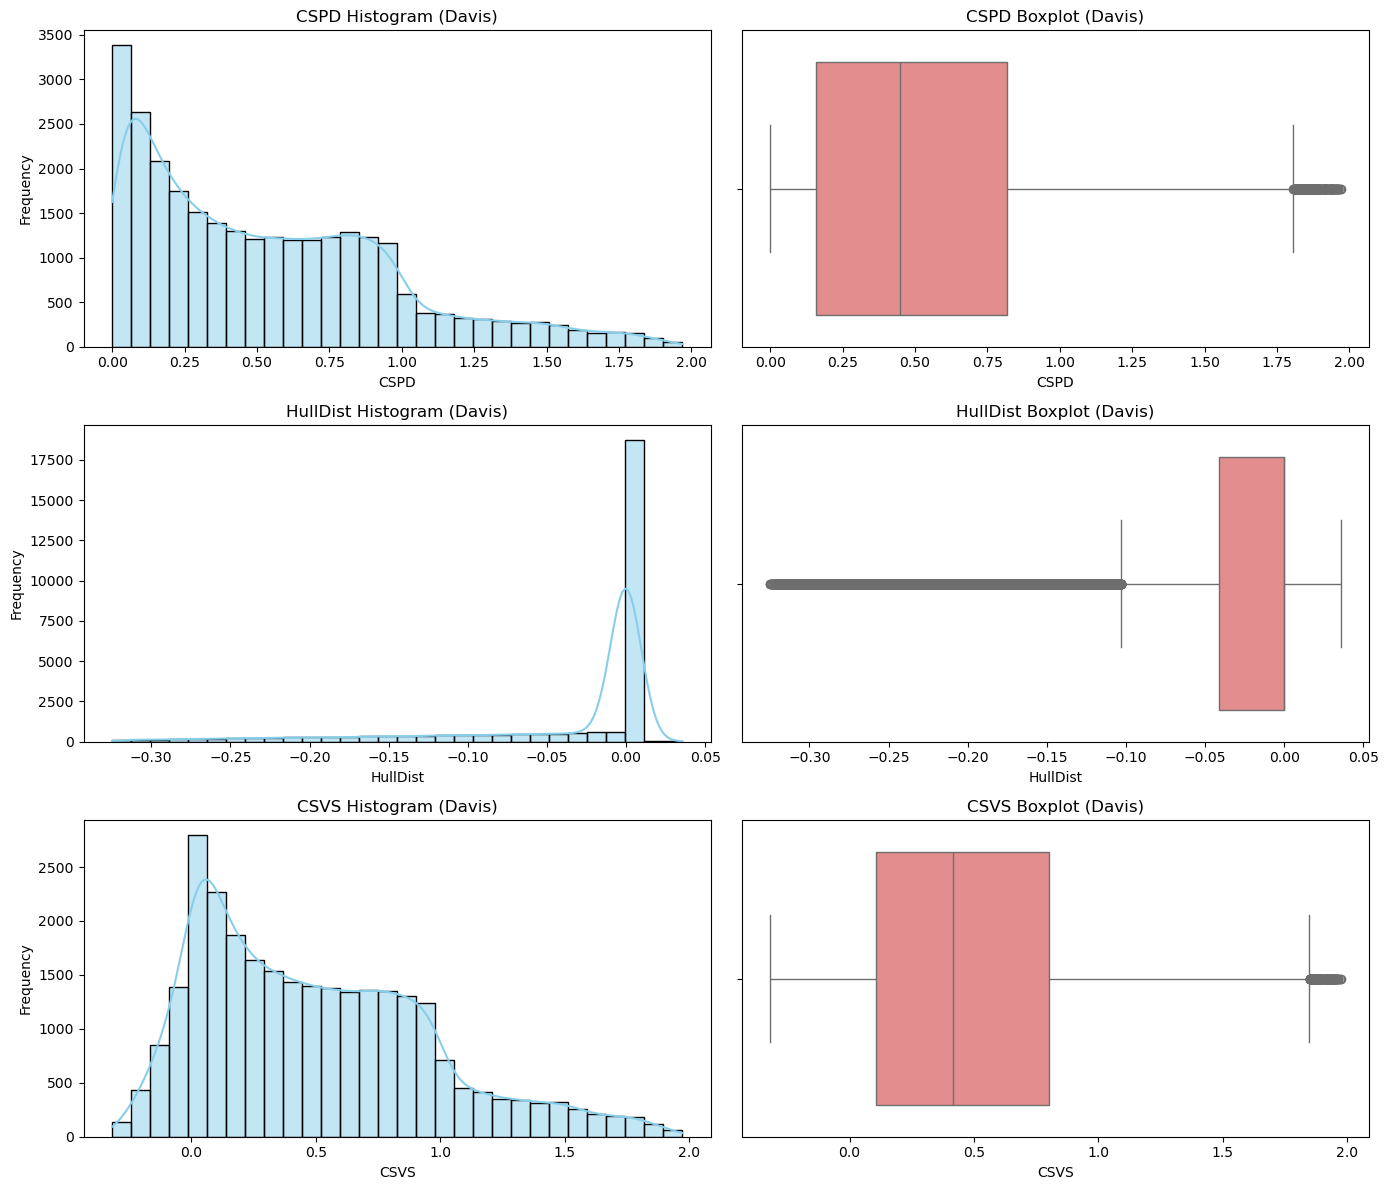

In [252]:
visualize_csvs_metrics(pharos_with_csvs, label="Pharos")
visualize_csvs_metrics(davis_with_csvs, label="Davis")


for each pharos point compute its k most triplet (drug,prot,blinded pred affinity) similar neightbors and return a df of those neighbors 

In [327]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def build_neighborhood_df_for_pharos_point(
    pharos_point,
    davis_df,
    protein_embeddings,
    drug_embeddings,
    max_affinity=10.0,
    top_k=5
):
    """
    Build a neighborhood DataFrame of the top-k most similar Davis triplets for a given Pharos point.
    """
    pid, did, pred_aff = pharos_point["Protein_ID"], pharos_point["Drug_ID"], pharos_point["Predicted_Value"]

    # Skip if embeddings are missing
    if pid not in protein_embeddings or did not in drug_embeddings:
        return None

    # Construct query embedding (triplet: protein, drug, normalized affinity)
    query_vec = np.concatenate([
        protein_embeddings[pid],
        drug_embeddings[did],
        [pred_aff / max_affinity]
    ])

    # Build embeddings for valid Davis triplets
    davis_embeddings = np.stack([
        np.concatenate([
            protein_embeddings[row["Protein_ID"]],
            drug_embeddings[row["Drug_ID"]],
            [row["Blinded_Prediction"] / max_affinity]
        ])
        for _, row in davis_df.iterrows()
    ])

    # Compute cosine similarity
    sim_scores = cosine_similarity([query_vec], davis_embeddings)[0]
    top_idxs = np.argsort(sim_scores)[-top_k:]
    neighborhood_df = davis_df.iloc[top_idxs].copy()
    neighborhood_df["similarity"] = sim_scores[top_idxs]

    return neighborhood_df.reset_index(drop=True)


In [328]:
neighborhoods = {}

for _, pharos_point in pharos_df.iterrows():
    key = (
        pharos_point["Drug_ID"],
        pharos_point["Protein_ID"],
        pharos_point["Predicted_Value"]
    )
    
    n_df = build_neighborhood_df_for_pharos_point(
        pharos_point,
        davis_with_csvs,
        protein_embeddings,
        drug_embeddings
    )
    
    if n_df is not None:
        neighborhoods[key] = n_df


Then compute metrics defined over the davis blinded k neighborhood and infer csvs of the pharos point 

CSV inferred =αCSPD+βCHR+γ(1−Coherence)+δConformity ratio

CSPD of each neighbor (already a column in davis_with_csvs) averaged and weighted by its similarity score to pharos

CHR = # points in neighborhood outside of hull /# points in neighborhood * max neighborhood distance from hull   (or again just do weighted average avg dist from hull)

Direction Coherence: how aligned are the direction vectors of the davis points from the hull? Ranges from -1 (opposing directions) to 1 (perfect alignment) (coherence = np.linalg.norm(mean_vector))

Conformity ratio =  weighted average of each neighborhood members conformity change (which is ratio of unblinded conformity to blinded conformity (Top of fraction: # of unblinded proteins that are closer to the hull than my unblinded distance/ total # of unblinded proteins)

Bottom of fraction: # of unblinded proteins that are closer to the hull than my blinded distance / total # of unblinded proteins)

Note: convex hull in all metrics is defined by the davis_unblinded set

In [335]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
from shapely.geometry import Polygon, Point

def compute_signed_distance_to_hull(polygon, delaunay, point):
    p = Point(point)
    if polygon.contains(p) or polygon.touches(p):
        return -polygon.exterior.distance(p)
    else:
        return polygon.exterior.distance(p)

def compute_inferred_csvs_for_pharos_point(
    pharos_point,
    neighborhood_df,
    davis_unblinded_df,
    alpha=1.0,
    beta=1.0,
    gamma=1.0,
    delta=1.0
):
    """
    Compute inferred CSVS for a Pharos point using its Davis neighborhood and convex hull from unblinded data.
    Assumes neighborhood_df already has: true_norm, pred_norm, HullDist, delta_vec, unblinded_dist, similarity, CSPD.
    """
    if neighborhood_df is None or neighborhood_df.empty:
        return np.nan, {}

    # Normalize weights
    similarities = neighborhood_df["similarity"].values
    weights = similarities / similarities.sum()

    # 1. CSPD
    weighted_cspd = np.average(neighborhood_df["CSPD"].values, weights=weights)

    # 2. Hull Risk
    weighted_hull_risk = np.average(neighborhood_df["HullDist"].values, weights=weights)

    # 3. Coherence
    delta_vecs = np.stack(neighborhood_df["delta_vec"].values)
    mean_vec = np.average(delta_vecs, axis=0, weights=weights)
    coherence = np.linalg.norm(mean_vec) / (np.sum(weights) + 1e-8)
    incoherence = 1 - coherence

    # 4. Conformity score
    conformity_scores = neighborhood_df["conformity_score"].values
    weighted_conformity_ratio = np.average(conformity_scores, weights=weights)


    # Final CSVS score
    inferred_csvs = (
        alpha * weighted_cspd +
        beta * weighted_hull_risk +
        gamma * incoherence +
        delta * weighted_conformity_ratio
    )

    return inferred_csvs, {
        "weighted_cspd": weighted_cspd,
        "weighted_hull_risk": weighted_hull_risk,
        "incoherence": incoherence,
        "weighted_conformity_ratio": weighted_conformity_ratio
    }


In [336]:
results = []

print(neighborhood_df.columns)

for _, row in pharos_df.iterrows():
    key = (row["Drug_ID"], row["Protein_ID"], row["Predicted_Value"])
    neighborhood_df = neighborhoods.get(key, None)

    inferred_csvs, details = compute_inferred_csvs_for_pharos_point(
        pharos_point=row,
        neighborhood_df=neighborhood_df,
        davis_unblinded_df=unblinded_df,  # or davis_unblinded_df if that's the correct variable name
        alpha=1.0,
        beta=1.0,
        gamma=1.0,
        delta=1.0
    )

    results.append({
        "Drug_ID": row["Drug_ID"],
        "Protein_ID": row["Protein_ID"],
        "Predicted_Value": row["Predicted_Value"],
        "Inferred_CSVS": inferred_csvs,
        **details
    })

inferred_csvs_df = pd.DataFrame(results)


Index(['Protein_ID', 'Drug_ID', 'True_Label', 'Blinded_Prediction', 'CSPD',
       'HullDist', 'delta_vec', 'CSVS', 'Unblinded_Prediction',
       'unblinded_dist', 'blinded_dist', 'top_fraction', 'bottom_fraction',
       'conformity_score', 'similarity'],
      dtype='object')


then infer the csvs and a confidence interval of the pharos point based on the averages and similarities from the neighbors

        davis_df["Protein_ID"].isin(protein_embeddings) &
        davis_df["Drug_ID"].isin(drug_embeddings) &
        davis_df["Predicted_Value"].notnull() &
        davis_df["True_Label"].notnull() &
        davis_df["CHR"].notnull()  - how many of the k neighbors fall outside the convex hull of all unblinded points when plotting predicted_value vs true_label

        davis_df["CSPD"].notnull() - avg cold start predition deviation where each neighborhood members contribution is weighted by level of similarity to pharos protein
        davis_df["distance"].notnull() & - avg distance from hull (signed)
        davis_df["direction"].notnull() & - avg direction vector
        davis_df["coherence"] - how coherent the deviation vectors are to one another
        davis_df["conf_unblind"].notnull() and
        davis_df["conf_blind"].notnull() - Have a reference set: all the unblinded predictions, and how close they are to the hull (how conforming they are).
“Where does my unblinded/blinded prediction sit in that distribution of conformity?”

then compute the true csvs of each pharos point which i will now define as: 
CSVs = Prediction Error (cspd) + Hull Risk(signed dist from hull) + Conformity Penalty ( )

can scale predictions and trues to 0 to 1 or rank based since they prob have quite different ranges

In [337]:
print(pharos_with_csvs.columns)
print(inferred_csvs_df.columns)

Index(['Protein_ID', 'Drug_ID', 'True_Label', 'Predicted_Value', 'CSPD',
       'HullDist', 'delta_vec', 'CSVS'],
      dtype='object')
Index(['Drug_ID', 'Protein_ID', 'Predicted_Value', 'Inferred_CSVS',
       'weighted_cspd', 'weighted_hull_risk', 'incoherence',
       'weighted_conformity_ratio'],
      dtype='object')


In [345]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_csvs_vs_inferred(pharos_with_csvs, inferred_csvs_df):
    """
    Plot true CSVS vs inferred CSVS for Pharos predictions.
    """
    # Merge on Drug_ID, Protein_ID, and Predicted_Value
    merged = pd.merge(
        pharos_with_csvs,
        inferred_csvs_df,
        on=["Drug_ID", "Protein_ID", "Predicted_Value"],
        how="inner"
    )
    from scipy.stats import spearmanr
    rho, pval = spearmanr(merged["CSVS"], merged["Inferred_CSVS"])
    print(f"Spearman ρ = {rho:.3f}, p = {pval:.3g}")
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=merged, x="CSVS", y="Inferred_CSVS", alpha=0.6)
    plt.plot([merged["CSVS"].min(), merged["CSVS"].max()],
             [merged["CSVS"].min(), merged["CSVS"].max()],
             color='red', linestyle='--', label='y = x')

    plt.xlabel("True CSVS (from Pharos)")
    plt.ylabel("Inferred CSVS (from Davis neighborhood)")
    plt.title("CSVS vs Inferred CSVS on Pharos Predictions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Spearman ρ = 0.039, p = 0.338


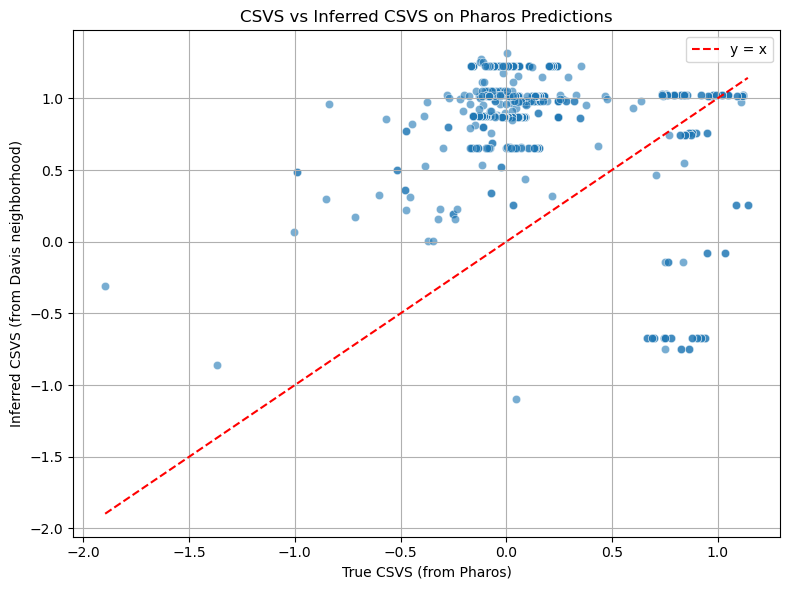

In [344]:
plot_csvs_vs_inferred(pharos_with_csvs, inferred_csvs_df)

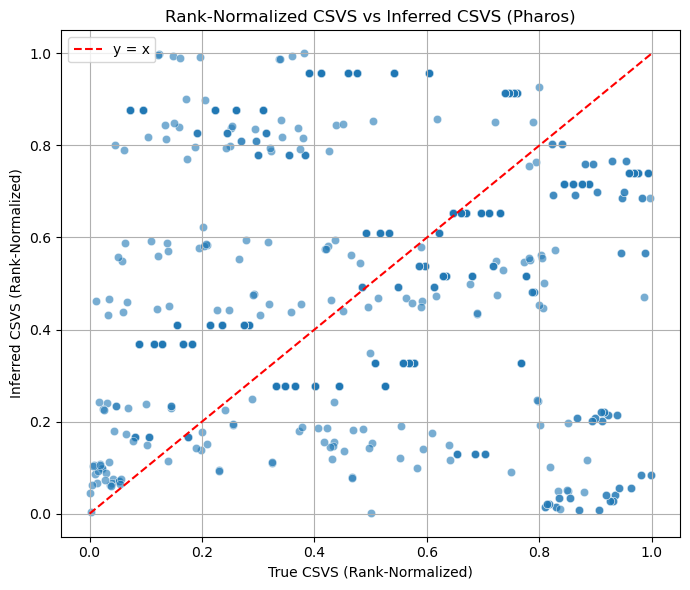

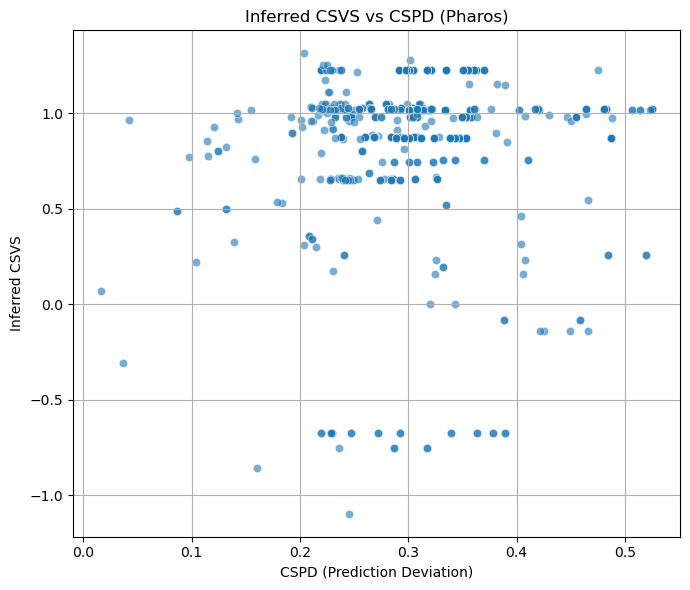

Spearman ρ (True CSVS vs Inferred) = 0.039, p = 0.338
Spearman ρ (CSPD vs Inferred CSVS) = 0.093, p = 0.0205


In [348]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

# Merge actual and inferred CSVS
merged = pd.merge(
    pharos_with_csvs,
    inferred_csvs_df,
    on=["Drug_ID", "Protein_ID", "Predicted_Value"],
    how="inner"
)

# Compute rank-normalized CSVS for visualization
merged["CSVS_rank"] = merged["CSVS"].rank(method="average") / len(merged)
merged["Inferred_CSVS_rank"] = merged["Inferred_CSVS"].rank(method="average") / len(merged)

# --- Plot 1: Rank-Normalized CSVS vs Inferred CSVS ---
plt.figure(figsize=(7, 6))
sns.scatterplot(data=merged, x="CSVS_rank", y="Inferred_CSVS_rank", alpha=0.6)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='y = x')
plt.xlabel("True CSVS (Rank-Normalized)")
plt.ylabel("Inferred CSVS (Rank-Normalized)")
plt.title("Rank-Normalized CSVS vs Inferred CSVS (Pharos)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Inferred CSVS vs CSPD ---
plt.figure(figsize=(7, 6))
sns.scatterplot(data=merged, x="CSPD", y="Inferred_CSVS", alpha=0.6)
plt.xlabel("CSPD (Prediction Deviation)")
plt.ylabel("Inferred CSVS")
plt.title("Inferred CSVS vs CSPD (Pharos)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Correlation metrics ---
rho1, pval1 = spearmanr(merged["CSVS"], merged["Inferred_CSVS"])
rho2, pval2 = spearmanr(merged["CSPD"], merged["Inferred_CSVS"])

print(f"Spearman ρ (True CSVS vs Inferred) = {rho1:.3f}, p = {pval1:.3g}")
print(f"Spearman ρ (CSPD vs Inferred CSVS) = {rho2:.3f}, p = {pval2:.3g}")


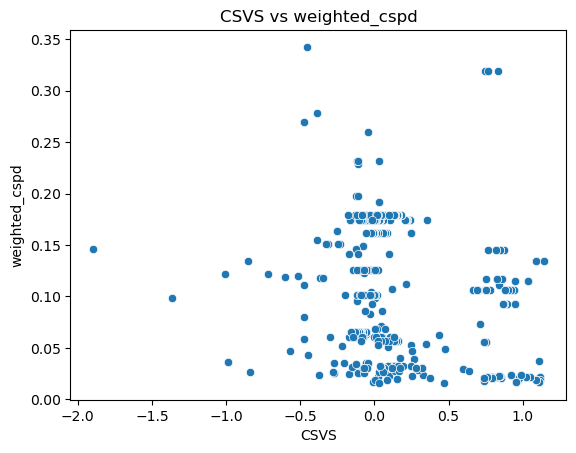

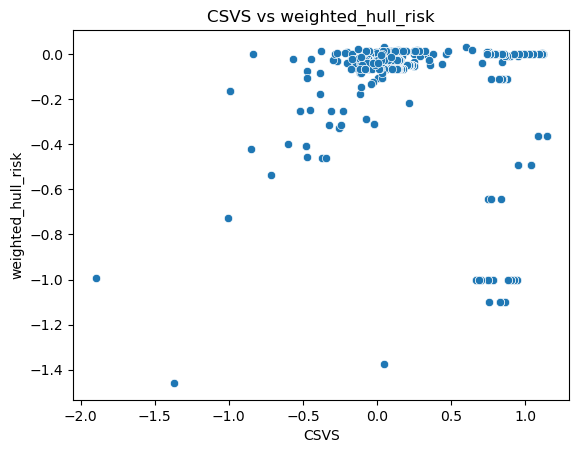

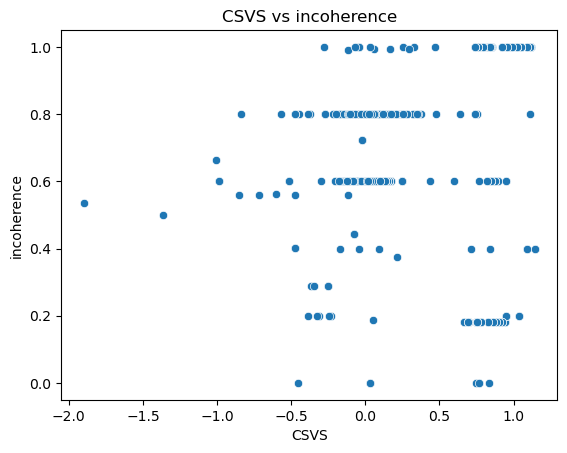

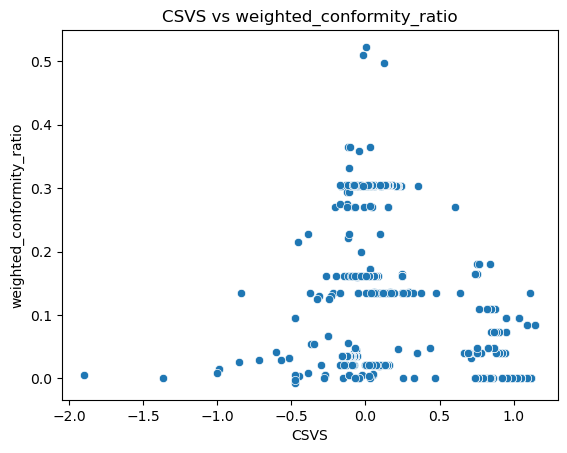

In [347]:
for col in ["weighted_cspd", "weighted_hull_risk", "incoherence", "weighted_conformity_ratio"]:
    sns.scatterplot(data=merged, x="CSVS", y=col)
    plt.title(f"CSVS vs {col}")
    plt.show()
